In [1]:
%%capture
!pip install linearmodels

In [2]:
%%capture
!pip install causalinference

In [3]:
from causalinference import CausalModel

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
# pd.set_option("display.max_columns", 6)

import graphviz as gr

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

%matplotlib inline

In [215]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [219]:
style.use('bmh')

In [224]:
plt.rcParams.update({'font.size': 9})

# 01 - Introduction To Causality

## When Association IS Causation

Intuitively, we kind of know why the association is not causation. If someone tells you that schools that give tablets to their students perform better than those that don’t, you can quickly point out that it is probably the case that those schools with the tablets are wealthier. As such, they would do better than average even without the tablets. Because of this, we can’t conclude that giving tablets to kids during classes will cause an increase in their academic performance. We can only say that tablets in school are associated with high academic performance, as measured by ENEM (sort of the SAT in Brazil, which stands for National High School Exam):

In [ ]:
np.random.seed(123)
n = 100
tuition = np.random.normal(1000, 300, n).round()
tablet = np.random.binomial(1, expit((tuition - tuition.mean()) / tuition.std())).astype(bool)
enem_score = np.random.normal(200 - 50 * tablet + 0.7 * tuition, 200)
enem_score = (enem_score - enem_score.min()) / enem_score.max()
enem_score *= 1000

data = pd.DataFrame(dict(enem_score=enem_score, Tuition=tuition, Tablet=tablet))

In [ ]:
data.head(9)

,enem_score,Tuition,Tablet
0,227.622953,674.0,False
1,219.079925,1299.0,True
2,400.889622,1085.0,False
3,122.761509,548.0,False
4,315.064276,826.0,False
5,687.073437,1495.0,False
6,115.442787,272.0,True
7,373.175133,871.0,False
8,585.333858,1380.0,True


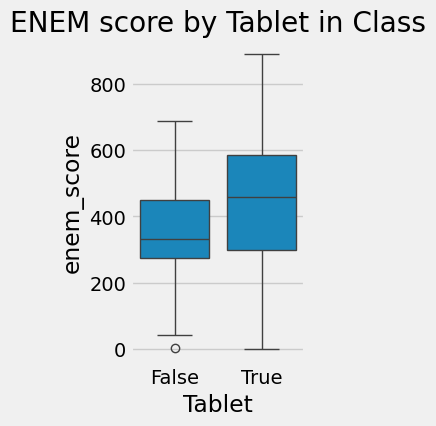

In [ ]:
plt.figure(figsize=(2,4))
sns.boxplot(y="enem_score", x="Tablet", data=data).set_title('ENEM score by Tablet in Class')
plt.show()

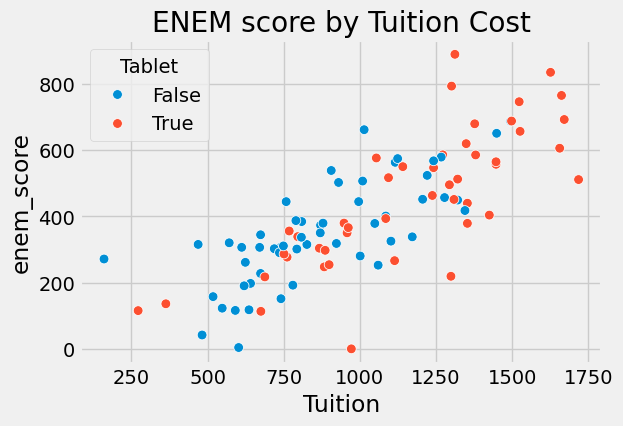

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="Tuition", y="enem_score", hue="Tablet", data=data, s=49).set_title('ENEM score by Tuition Cost')
plt.show()

# 02 - Randomised Experiments

Fortunately, some economists have done that for us. They've randomized classes so that some students were assigned to have face-to-face lectures, others to have only online lessons, and a third group to have a blended format of both online and face-to-face classes. They collected data on a standard exam at the end of the semester.

Here is what the data looks like:

In [ ]:
data = pd.read_csv("./data/online_classroom.csv")

print(data.shape)
data.head(11)

(323, 10)


,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000
5,0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0,88.34996
6,1,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,78.40000
7,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,90.00000
8,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,88.31000
9,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,73.37000


We can see that we have 323 samples. It's not exactly big data, but something we can work with. To estimate the causal effect, we can simply compute the mean score for each of the treatment groups.

In [ ]:
data.assign(class_format= np.select(
    [data["format_ol"].astype(bool), data["format_blended"].astype(bool)],
    ["online", "blended"],
    default="face_to_face"
)).groupby(["class_format"]).mean()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
class_format,,,,,,,,,,
blended,0.550459,0.217949,0.102564,0.025641,0.012821,0.012821,0.628205,0.0,1.0,77.093731
face_to_face,0.633333,0.202020,0.070707,0.000000,0.010101,0.000000,0.717172,0.0,0.0,78.547485
online,0.542553,0.228571,0.028571,0.014286,0.028571,0.000000,0.700000,1.0,0.0,73.635263


# 03 - Stats Review: The Most Dangerous Equation

In [ ]:
df = pd.read_csv('./data/enem_scores.csv')
df.sort_values(by='avg_score', ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


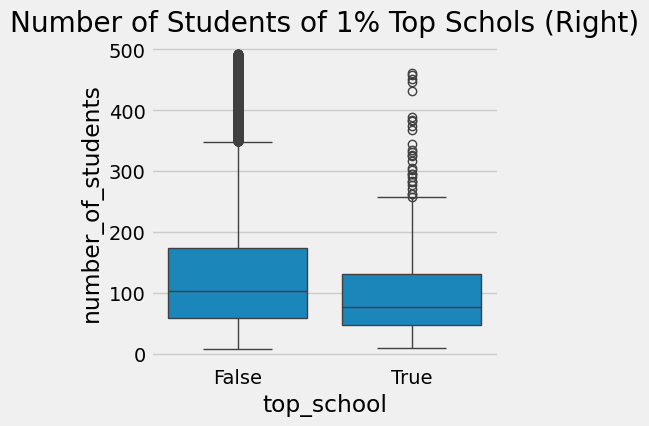

In [ ]:
plot_data = (df.assign(top_school = df['avg_score'] >= np.quantile(df['avg_score'], .99))
                    [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(4,4))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title('Number of Students of 1% Top Schols (Right)');

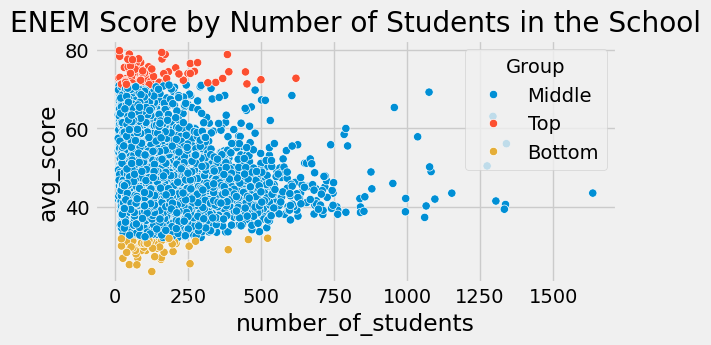

In [ ]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(6,3))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

In [ ]:
data = pd.read_csv('./data/online_classroom.csv')
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y:pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319104


## Confidence Intervals

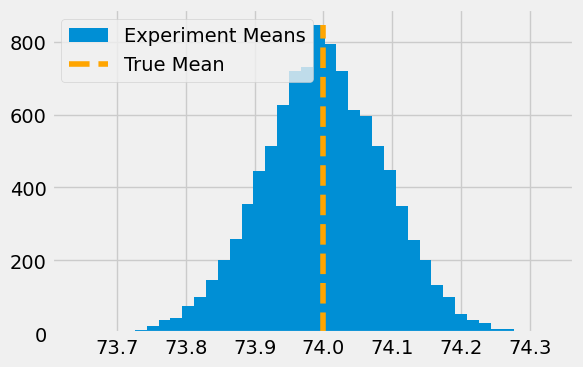

In [ ]:
true_std = 2
true_mean = 74

n = 500
def run_experiment():
    return np.random.normal(true_mean, true_std, 500)

np.random.seed(42)

plt.figure(figsize=(6, 4))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles='dashed', label='True Mean', color="orange")
plt.legend();

In [ ]:
np.random.seed(321)

exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()

ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)

print(ci[0], ci[1])

73.82718114045632 74.17341543460314


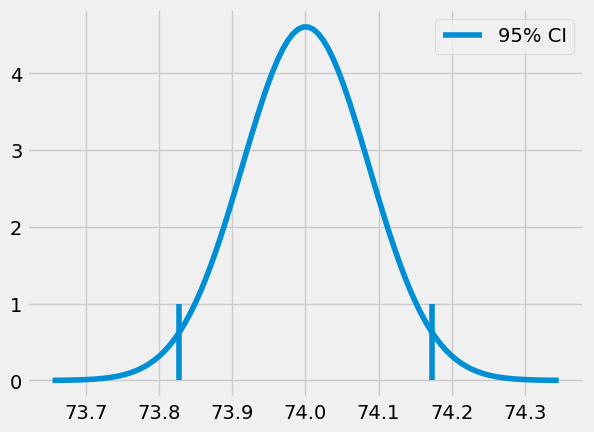

In [ ]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

In [ ]:
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(np.float64(73.7773381773405), np.float64(74.22325839771896))

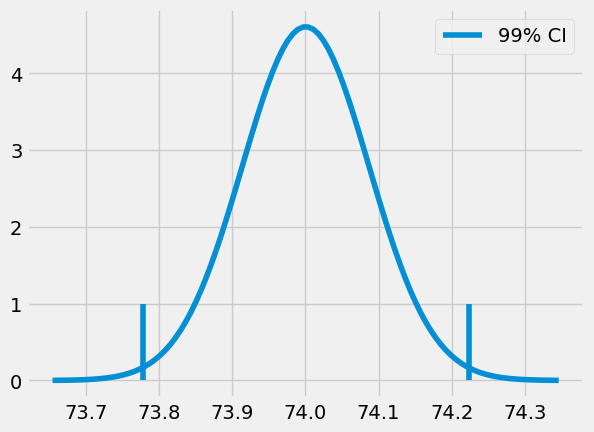

In [ ]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

In [ ]:
def se(y:pd.Series):
    return y.std() / np.sqrt(len(y))

def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% CI for Face to Face:", ci(face_to_face))

95% CI for Online: (np.float64(70.56094429049804), np.float64(76.7095818797147))
95% CI for Face to Face: (np.float64(76.80278229206951), np.float64(80.29218687459715))


## Hypothesis Testing

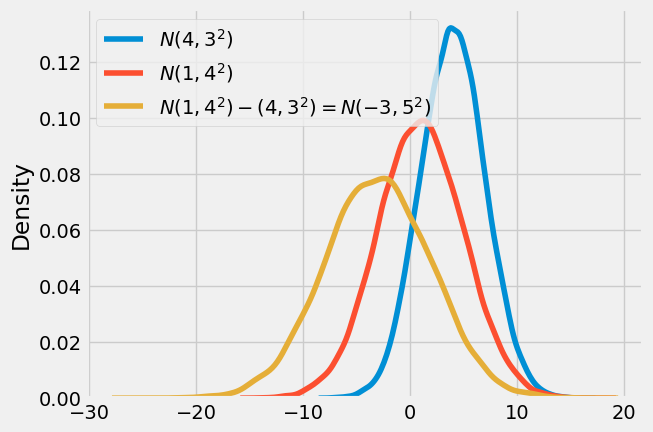

In [ ]:
np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1

sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

In [ ]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var() / len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(np.float64(-8.376410208363385), np.float64(-1.4480327880905248))


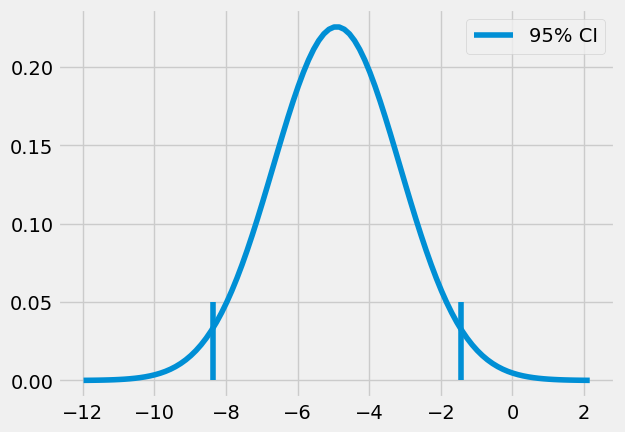

In [ ]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

In [ ]:
z = diff_mu / diff_se

print(z)

-2.7792810791031224


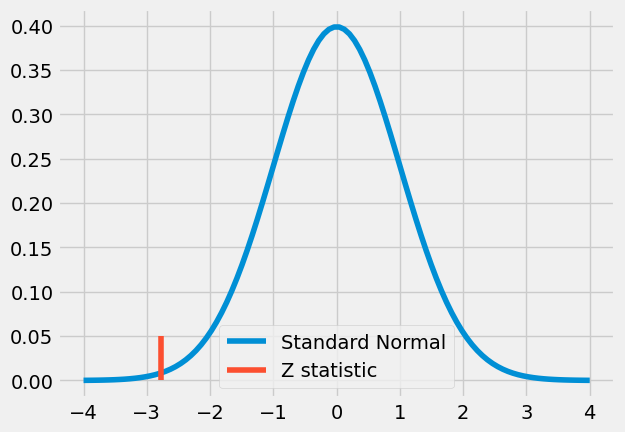

In [ ]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color='C1')
plt.legend()
plt.show()

In [ ]:
print("P-values:", stats.norm.cdf(z))

P-values: 0.0027239680835563383


In [ ]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))

95% CI: (np.float64(-8.376346553082909), np.float64(-1.4480964433710017))
99% CI: (np.float64(-9.46485353526404), np.float64(-0.3595894611898709))
99.9% CI: (np.float64(-10.728040658245558), np.float64(-0.3595894611898709))


In [ ]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))

    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))

    z_stats = (diff-h0) / se_diff
    p_value = stats.norm.cdf(z_stats)

    def critical(se): return -se*stats.norm.ppf((1 - confidence)/2)

    print(f"Test {confidence*100}% CI: {mu1} +- {critical(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critical(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critical(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")

AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


# 04 - Graphical Causal Models

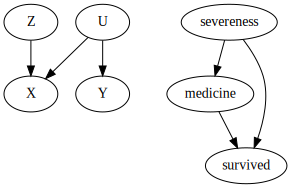

In [ ]:
g = gr.Digraph()
g.edge("Z", "X")
g.edge("U", "X")
g.edge("U", "Y")

g.edge("medicine", "survived")
g.edge("severeness", "survived")
g.edge("severeness", "medicine")

g

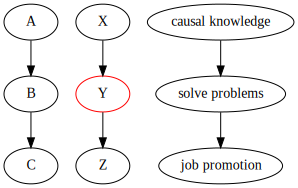

In [ ]:
g = gr.Digraph()
g.edge("A", "B")
g.edge("B", "C")

g.edge("X", "Y")
g.edge("Y", "Z")
g.node("Y", "Y", color="red")

g.edge("causal knowledge", "solve problems")
g.edge("solve problems", "job promotion")

g

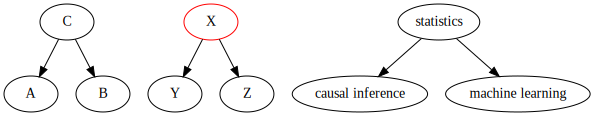

In [ ]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B")

g.edge("X", "Y")
g.edge("X", "Z")
g.node("X", "X", color='red')

g.edge("statistics", "causal inference")
g.edge("statistics", "machine learning")

g

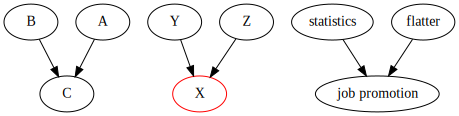

In [ ]:
g = gr.Digraph()
g.edge("B", "C")
g.edge("A", "C")

g.edge("Y", "X")
g.edge("Z", "X")
g.node("X", "X", color='red')

g.edge("statistics", "job promotion")
g.edge("flatter", "job promotion")

g

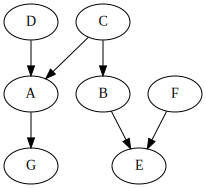

In [ ]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B")
g.edge("D", "A")
g.edge("B", "E")
g.edge("F", "E")
g.edge("A", "G")

g

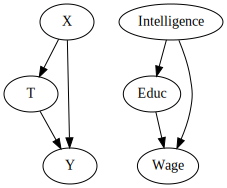

In [ ]:
g = gr.Digraph()
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")

g.edge("Intelligence", "Educ")
g.edge("Intelligence", "Wage")
g.edge("Educ", "Wage")

g

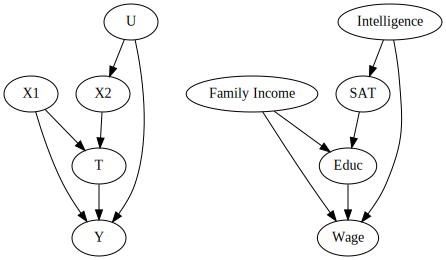

In [ ]:
g = gr.Digraph()
g.edge("X1", "T")
g.edge("T", "Y")
g.edge("X2", "T")
g.edge("X1", "Y")
g.edge("U", "X2")
g.edge("U", "Y")

g.edge("Family Income", "Educ")
g.edge("Educ", "Wage")
g.edge("SAT", "Educ")
g.edge("Family Income", "Wage")
g.edge("Intelligence", "SAT")
g.edge("Intelligence", "Wage")
g

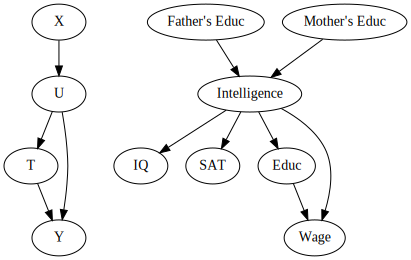

In [ ]:
g = gr.Digraph()
g.edge("X", "U")
g.edge("U", "T")
g.edge("T", "Y")
g.edge("U", "Y")

g.edge("Intelligence", "IQ")
g.edge("Intelligence", "SAT")
g.edge("Father's Educ", "Intelligence")
g.edge("Mother's Educ", "Intelligence")

g.edge("Intelligence", "Educ")
g.edge("Educ", "Wage")
g.edge("Intelligence", "Wage")

g

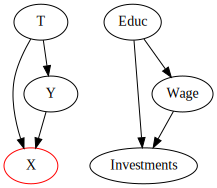

In [ ]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")
g.node("X", "X", color='red')

g.edge("Educ", "Investments")
g.edge("Educ", "Wage")
g.edge("Wage", "Investments")

g

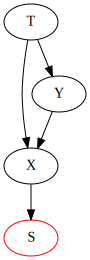

In [ ]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")
g.edge("X", "S")
g.node("S", "S", color="red")
g

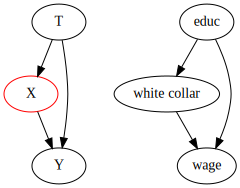

In [ ]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g.node("X", "X", color="red")

g.edge("educ", "white collar")
g.edge("educ", "wage")
g.edge("white collar", "wage")

g

# 05 - The Unreasonable Effectiveness of Linear Regression

In [ ]:
data = pd.read_csv('data/online_classroom.csv').query('format_blended==0')

result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


In [ ]:
data.groupby("format_ol")["falsexam"].mean()

,falsexam
format_ol,
0,78.547485
1,73.635263


## Regression Theory

$
\beta^* =\underset{\beta}{argmin} \ E[(Y_i - X_i'\beta)^2]
$

Linear regression finds the parameters that minimise the mean squared error (MSE).

If you differentiate it and set it to zero, you will find that the linear solution to this problem is given by

$
\beta^* = E[X_i'X_i]^{-1}E[X_i' Y_i]
$

We can estimate this beta using the sample equivalent:

$
\hat{\beta} = (X'X)^{-1}X' Y
$

In [ ]:
X = data[['format_ol']].assign(intercep=1)
y = data["falsexam"]

def regress(y, X):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([-4.9122215 , 78.54748458])

In [ ]:
X

,format_ol,intercep
0,0,1
1,0,1
4,1,1
5,1,1
7,0,1
...,...,...
316,0,1
317,0,1
319,1,1
320,1,1


With a single regressor variable $T$, the parameter associated to it will be given by

$
\beta_1 = \dfrac{Cov(Y_i, T_i)}{Var(T_i)}
$

If $T$ is randomly assigned, $\beta_1$ is the ATE.

In [ ]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()

kapa

np.float64(-4.912221498226952)

If we have more than one regressor, we can extend the following formula to accommodate that. Let's say those other variables are just auxiliary and that we are truly interested only in estimating the parameter $\kappa$ associated to $T$.

$
y_i = \beta_0 + \kappa T_i + \beta_1 X_{1i} + ... +\beta_k X_{ki} + u_i
$

$\kappa$ can be obtained with the following formula

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}
$

where $\tilde{T_i}$ is the residual from a regression of $T_i$ on all other covariates $X_{1i}, ..., X_{ki}$. Now, let's appreciate how cool this is. It means that the coefficient of a multivariate regression is the bivariate coefficient of the same regressor **after accounting for the effect of other variables in the model**. In causal inference terms, $\kappa$ is the bivariate coefficient of $T$ after having used all other variables to predict it.

This has a nice intuition behind it. If we can predict $T$ using other variables, it means it's not random. However, we can make it so that $T$ is as good as random once we control for other available variables. To do so, we use linear regression to predict it from the other variables and then we take the residuals of that regression $\tilde{T}$. By definition, $\tilde{T}$ cannot be predicted by the other variables $X$ that we've already used to predict $T$. Quite elegantly, $\tilde{T}$ is a version of the treatment that is not associated with any other variable in $X$.

By the way, this is also a property of linear regression. The residual are always orthogonal or uncorrelated with any of the variables in the model that created it:

In [ ]:
e = y - X.dot(beta)
print("Orthogonality imply that the dot product is zero:", np.dot(e, X))
X[['format_ol']].assign(e=e).corr()

Orthogonality imply that the dot product is zero: [-5.11590770e-13  3.34665629e-12]


,format_ol,e
format_ol,1.000000e+00,-1.545493e-15
e,-1.545493e-15,1.000000e+00


## Regression For Non-Random Data

First, let's estimate a very simple model. We will regress log hourly wages on years of education. We use logs here so that our parameter estimates have a percentage interpretation. With it, we will be able to say that 1 extra year of education yields a wage increase of x%.


$
log(hwage)_i = \beta_0 + \beta_1 educ_i + u_i
$

In [ ]:
wage = pd.read_csv('./data/wage.csv').dropna()
model_1 = smf.ols('np.log(hwage) ~ educ', data=wage.assign(hwage=wage["wage"]/wage['hours'])).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


The estimate of $\beta_1$ is 0.0536, with a 95% confidence interval of (0.039, 0.068). This means that this model predicts that wages will increase about 5.3% for every additional year of education. This percentage increase is inline with the belief that education impacts wages in an exponential fashion: we expect that going from 11 to 12 years of education (average to graduate high school) to be less rewarding than going from 14 to 16 years (average to graduate college).

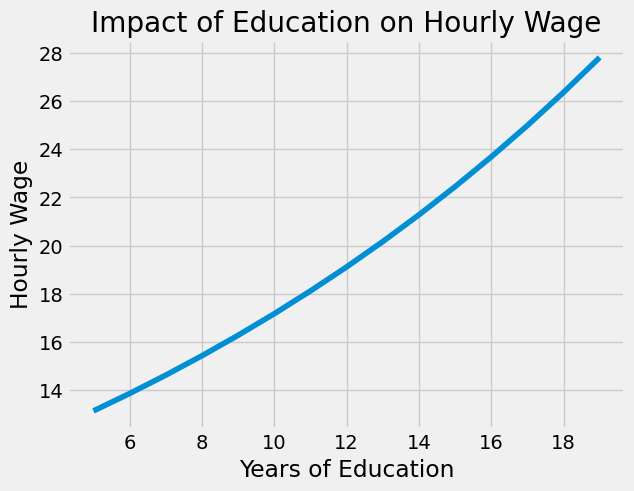

In [ ]:
x = np.array(range(5, 20))
plt.plot(x, np.exp(model_1.params['Intercept'] + model_1.params['educ'] * x))
plt.xlabel('Years of Education')
plt.ylabel('Hourly Wage')
plt.title('Impact of Education on Hourly Wage')
plt.show()

In [ ]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


We can include all those extra variables in a model and estimate it:

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}X_i + u_i
$

To understand how this helps with the bias problem, let's recap the bivariate breakdown of multivariate linear regression.

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}
$

This formula says that we can predict `educ` from the parents' education, from IQ, from experience and so on. After we do that, we'll be left with a version of `educ`, $\tilde{educ}$, which is uncorrelated with all the variables included previously. This will break down arguments such as "people that have more years of education have it because they have higher IQ. It is not the case that education leads to higher wages. It is just the case that it is correlated with IQ, which is what drives wages". Well, if we include IQ in our model, then $\kappa$ becomes the return of an additional year of education while keeping IQ fixed. Pause a little bit to understand what this implies. Even if we can't use randomised controlled trials to keep other factors equal between treated and untreated, regression can do this by including those same factors in the model, even if the data is not random!

In [ ]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage['educ']
y = wage['lhwage']

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

np.float64(0.04114719101005691)

This coefficient we've just estimated tells us that, for people with the same IQ, experience, tenure, age and so on, we should expect an additional year of education to be associated with a 4.11% increase in hourly wage. This confirms our suspicion that the first simple model with only `educ` was biased. It also confirms that this bias was overestimating the impact of education. Once we controlled for other factors, the estimated impact of education fell.

If we are wiser and use software that other people wrote instead of coding everything yourself, we can even place a confidence interval around this estimate.

In [ ]:
model_2 = smf.ols("lhwage ~ educ +" + '+'.join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


## Omitted Variable or Confounding Bias

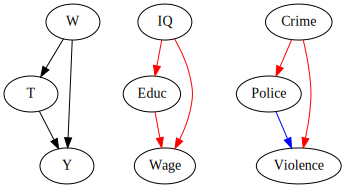

In [ ]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Educ", color="red"), g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g.edge("Crime", "Police", color="red"), g.edge("Crime", "Violence", color="red"),
g.edge("Police", "Violence", color="blue")

g

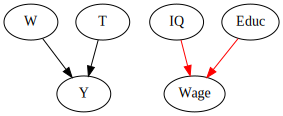

In [ ]:
g = gr.Digraph()

g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g

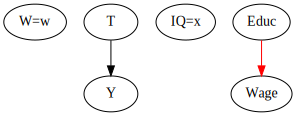

In [ ]:
g = gr.Digraph()

g.node("W=w"), g.edge("T", "Y")
g.node("IQ=x"), g.edge("Educ", "Wage", color="red")

g

# 06 - Grouped and Dummy Regression

## Regression With Grouped Data

Not all data points are created equal. If we look again at our ENEM dataset, we trust the scores of big schools much more than the scores from small schools. This is not to say that big schools are better or anything. It is just due to the fact that their big size imply less variance.

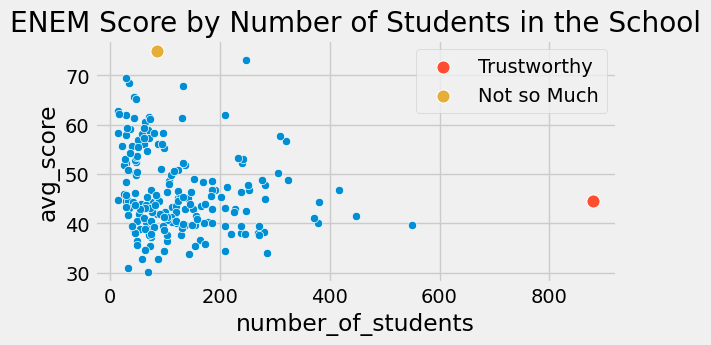

In [ ]:
np.random.seed(876)
enem = pd.read_csv('./data/enem_scores.csv').sample(200)
plt.figure(figsize=(6,3))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s = 90, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=90, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

In [ ]:
wage = pd.read_csv('./data/wage.csv')[['wage', 'lhwage', 'educ', 'IQ']]
wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


If we run a regression model to figure out how education is associated with log hourly wages, we get the following result.

In [ ]:
model_1 = smf.ols("lhwage ~ educ", data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


Now, let's pretend for a moment that this data was under some confidentiality constraint. The provider of it was not able to give individualised data. So we ask him instead to group everyone by years of education and give us only the mean log hourly wage and the number of individuals in each group. This leaves us with only 10 data points.

In [ ]:
group_wage = wage.assign(count=1).groupby("educ").agg({"lhwage":"mean", "count":"count"}).reset_index()

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


Fear not! Regression doesn't need big data to work! What we can do is provide weights to our linear regression model. This way, it will consider groups with higher sample size more than the small groups. Notice how I've replaced the `smf.ols` with `smf.wls`, for weighted least squares. It's hard to notice, but it will make all the difference.

In [ ]:
model_2 = smf.wls("lhwage ~ educ", data=group_wage, weights=group_wage['count']).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


Notice how the parameter estimate of `educ` in the grouped model is very close to the one in the ungrouped data (actually, they are the same in this case). Also, even with only 10 data points, we've managed to get a statistically significant coefficient. That's because, although we have fewer points, grouping also lowers the variance by a lot. Also notice how the standard error is a bit smaller and the t statistics is a bit larger. That's because some information about the variance is lost, so we have to be more conservative. Once we group the data, we don't know how large the variance is within each group. Compare the results above with what we would have with the non weighted model below.

In [ ]:
model_3 = smf.ols("lhwage ~ educ", data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


The parameter estimate is smaller. What is happening here is that the regression is placing equal weight for all points. If we plot the model along the grouped points, we see that the non weighted model is giving more importance to  small points in the lower left than it should. As a consequence, the line has a lower slope.

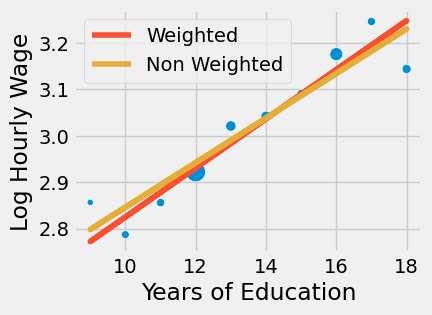

In [ ]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x="educ", y="lhwage", size="count", legend=False, data=group_wage, sizes=(20, 200))
plt.plot(wage['educ'], model_2.predict(wage['educ']), c='C1', label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

The bottom line is that regression is this marvellous tool that works both with individual or aggregated data, but you have to use weights in this last case. To use weighted regression you need mean statistics. Not sums, not standard deviations, not medians, but means! For both the covariates and the dependent variable. Just keep in mind that the result of weighted regression with grouped data won't match exactly that of regression in ungrouped data, but it will be pretty similar.

I'll finish with a final example using additional covariates in a grouped data model.

In [ ]:
group_wage = (wage.assign(count=1)
                        .groupby("educ")
                        .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
                        .reset_index())

model_4 = smf.wls("lhwage ~ educ + IQ", data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8821,0.324,5.800,0.001,1.115,2.649
educ,0.0257,0.021,1.198,0.270,-0.025,0.077
IQ,0.0077,0.006,1.309,0.232,-0.006,0.022


In this example, we've included IQ as a feature, besides the previously added years of education. The mechanics is pretty much the same: get the means and count, regress the mean and use the count as weights.



## Regression for Dummies

Dummy variables are categorical variables we've encoded as binary columns. For example, suppose you have a gender variable that you wish to include in your model. This variable is encoded into 3 categories: male, female and other genders.

|gender|
|------|
|male  |
|female|
|female|
|other |
|male  |

Since our model only accepts numerical values, we need to convert this category to a number. In linear regression, we use dummies for that. We encode each variable as a 0/1 column, denoting the presence of a category. We also leave one of the categories out as the base category. This is necessary since the last category is a linear combination of the others. Put it differently, we can know the last category if someone gives us information on the others. In our example, if someone is neither female nor other genders, we can infer that the person's category is male.

|gender|female|other|
|------|:-----|:----|
|male  |0|0|
|female|1|0|
|female|1|0|
|other |0|1|
|male  |0|0|

We've already dealt with a simple form of dummy regression when dealing with A/B testing. More generally, when we are dealing with a binary treatment, we represent it as a dummy variable. In this case, **the regression coefficient for that dummy is the increment for the intercept in the regression line**, or the difference in means between the treated and untreated.

To make this more concrete, consider the problem of estimating the effect of graduating 12th grade on hourly wage (and let's ignore confounding just for now). In the code below, we've created a treatment dummy variable `T` indicating if years of education is greater than 12.

In [ ]:
wage = (pd.read_csv('./data/wage.csv')
                                .assign(hwage=lambda d: d["wage"] / d["hours"])
                                .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[['hwage', "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


The dummy works as a kind of switch. In our example, if the dummy is on, the predicted value is the intercept plus the dummy coefficient. If the dummy is off, the predicted value is just the intercept.

In [ ]:
smf.ols("hwage ~ T", data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


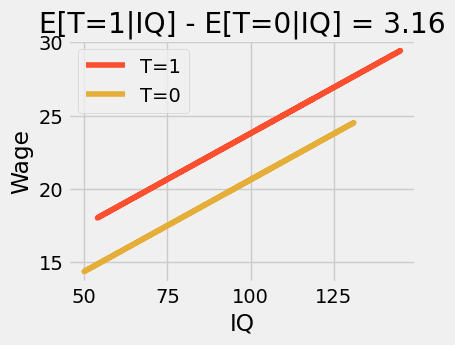

In [ ]:
plt.figure(figsize=(4,3))
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

If we put this model into an equation, we can see why:

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + e_i
$

Here, $\beta_1$ is the conditional difference in means and it is a constant value, 3.16 in our case. We can make this model more flexible by adding an interaction term.

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + \beta_3 IQ_i * T_i  + e_i
$

Things are getting a little bit more complex, so let's see what each parameter means in this model. First, the intercept $\beta_0$. This bad boy doesn't have a particularly interesting interpretation. It's the expected wage when the treatment is zero (the person hasn't graduated from 12th grade) AND the IQ is zero. Since we don't expect IQ to be zero for anyone this parameter is not very meaningful. As for $\beta_1$, we have a similar situation. This parameter is how much increase in wage we should expect from completing 12th grade **when IQ is zero**. Once again, since IQ is never zero, it doesn't have a particularly interesting meaning. Now, $\beta_2$ is a bit more interesting. It tells us how much IQ increases wages **for the non-treated**. So, in our case, it is something like 0.11. This means that for each 1 extra IQ point, the person that has not completed 12th grade should expect to gain an extra 11 cents per hour. Finally, the most interesting parameter is $\beta_3$. It tells us how much IQ increases the effect of graduating 12th grade. In our case, this parameter is 0.024, which means that for each extra IQ point, graduating 12th grade gives 2 extra cents. This might not seem much, but compare someone with 60IQ and with 140IQ. The first one will get an increase of 1.44 in wage (60 * 0.024), while the person with 140 IQ will gain an extra 3.36 dollars (140 * 0.024) when graduating from 12th grade.

In simple modeling jargon, this interaction term allows the treatment effect to change by levels of the features (only IQ, in this example). The result is that if we plot the prediction lines, we will see that they are no longer parallel and that those that graduate 12th grade (T=1) have a higher slope on IQ, higher IQ benefit more from graduating than lower IQ. This is sometimes referenced as effect modification or heterogeneous treatment effect.

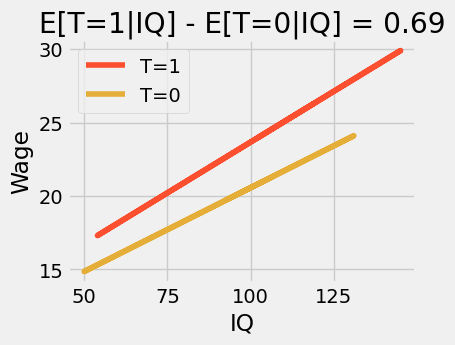

In [ ]:
plt.figure(figsize=(4,3))
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

In [ ]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


Treating education as a category, we no longer restrict the effect of education to a single parameter. Instead, we allow each year of education to have its own distinct impact. By doing so, we gain flexibility, since the effect of education is no longer parametric. This model simply computes the mean wage for each year of education.

In [ ]:
model_dummy = smf.ols("hwage ~ C(educ)", data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


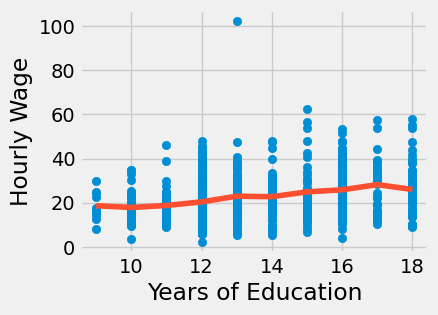

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

In [ ]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.590472362353516


In [ ]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(educ)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(educ)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(educ)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(educ)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(educ)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(educ)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(educ)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(educ)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(educ)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886


# 07 - Beyond Confounders

## Good Controls

In [ ]:
data = pd.read_csv('./data/collections_email.csv')
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


Since the data is random, you know that a simple difference in means estimates the Average Treatment Effect. In other words, nothing can have caused the treatment but the randomisation, so the potential outcomes are independent of the treatment: $(Y_0, Y_1)\perp T$.

$
ATE = E[Y|T=1] - E[Y|T=0]
$

Since you are smart and want to place a confidence interval around your estimate, you use a linear regression.

In [ ]:
print("Difference in means:",
      data.query("email==1")['payments'].mean() - data.query("email==0")["payments"].mean())

model = smf.ols("payments ~ email", data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


Sadly, the estimated ATE is -0.62, which is pretty weird. How can sending an email make late customers pay less than average? Still, the P-value is so high that this probably doesn't mean anything. What you should do now? Go back to your team with a tail between your legs and say that the test is inconclusive and you need more data? Not so fast.

Notice how your data has some other interesting columns. For example, `credit_limit` represents the customer's credit line prior to he or she getting late. `risk_score` corresponds to the estimated risk of the customer prior to the delivery of the email. It makes sense to think that credit limit and risk are probably very good predictors of payments. But how can that be useful?

First, let's understand why we can fail to find statistical significance in a treatment even when it is there. It could be that, like in this case, the treatment has very little impact on the outcome. If you think about it, what makes people pay their debt is, by and large, factors outside the control of the collections department. People pay their debt because they find a new job, manage their finances, income and so on. In statistical terms, we can say that **the variability of payments is explained much more by other factors other than by the email**.

To get a visual understanding of it, we can plot the payments against the treatment variable email. I've also plotted the fitted line of the model above in red. To help visualization, I've added a little bit of noise to the email variable so that it doesn't get smashed at the zero or one.

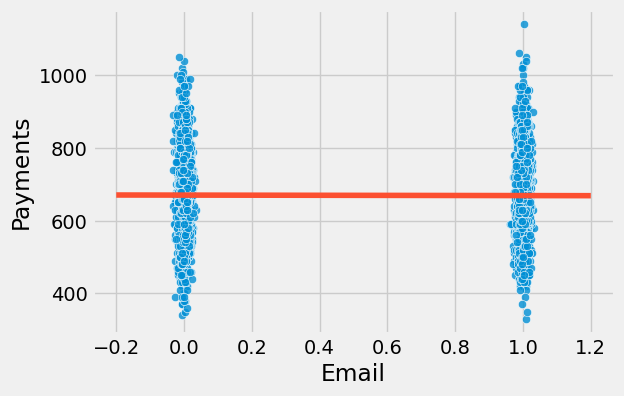

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="email", y="payments",
                alpha=0.8,
                data=data.assign(email=data['email'] + np.random.normal(0, 0.01, size=len(data['email']))))

plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel('Email')
plt.ylabel('Payments');

We can see how wildly payments vary in a single treatment group. Visually, it looks like it is going from a little bit under 400 to 1000 in both groups. If the impact of the email is in the order of say 5.00 or 10.00 R$, it is no wonder it will be hard to find it inside all the variability.

Fortunately, regression can help us lower this variability. The trick is to use additional controls. **If a variable is a good predictor of the outcome, it will explain away a lot of its variance**. If risk and credit limit are good predictors of payment, we can control them to make it easier to find the impact of the email on payments. If we remember how regression works, this has an intuitive explanation. Adding extra variables to a regression means keeping them constant while looking at the treatment. So, the reasoning goes, if we look at similar levels of risk and credit limit, the variance of the response variable `payments` should be smaller. Or, in other words, if risk and credit line predicts payments very well, customers with a similar risk and credit line should also have similar payment levels, hence with less variance.

To demonstrate this, let's resort to the partialling out way of breaking regression into 2 steps. First, we will regress the treatment, email, and the outcome, payments, on the additional controls, credit limit and risk score. Second, we will regress the residual of the treatment on the residuals of payments, both obtained in step 1. (This is purely pedagogical, in practice you won't need to go through all the hassle).

In [ ]:
model_email = smf.ols("email ~ credit_limit + risk_score", data=data).fit()
model_payments = smf.ols("payments ~ credit_limit + risk_score", data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols("res_payments ~ res_email", data=residuals).fit()

This lowers the variance of the dependent variable. By regressing payments on credit limit and risk and obtaining the residuals for this model, we are creating a new dependent variable with much less variability than the original one. The last model also uncovers the `ATE` with valid standard error estimate.

Just out of curiosity, we can also check that the model that predicts the treatment should not be able to lower the variance of it. That's because email is, by design, random, so nothing can predict it.

In [ ]:
print("Payments Variance:", np.var(data["payments"]))
print("Payments Residual Variance:", np.var(residuals["res_payments"]))

print("Email Variance:", np.var(data["email"]))
print("Email Residual Variance:", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance: 10807.61241599994
Payments Residual Variance: 5652.453558466198
Email Variance: 0.24991536000001294
Email Residual Variance: 0.24918421069820038


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.239e-13,1.063,-1.17e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


Notice how the variance of payments went from 10807 to 5652. We've decreased it by almost half once we control for risk and credit limits. Also notice that we didn't manage to reduce the variability of the treatment email. This makes sense, since risk and credit line does not predict email (nothing does, by definition of randomness).

Now, we see something much more reasonable. This new estimate tells us that we should expect customers that received the email to pay, on average, 4.4 reais more than those in the control group. This estimate is now statistically different from zero. We can also visualize how the variance is now lower within each control group.

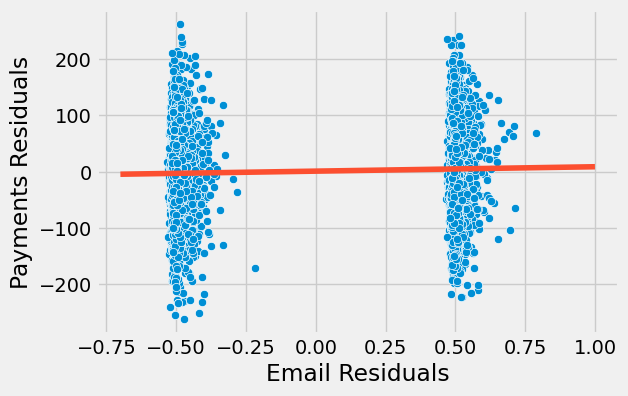

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

As I've said, we did this for pedagogical reasons. In practice, you can simply add the controls to the regression model together with the treatment and the estimates will be exactly the same.

In [ ]:
model_2 = smf.ols("payments ~ email + credit_limit + risk_score", data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


To wrap it up, anytime we have a control that is a good predictor of the outcome, even if it is not a confounder, adding it to our model is a good idea. It helps lowering the variance of our treatment effect estimates. Here is a picture of what this situation looks like with causal graphs.

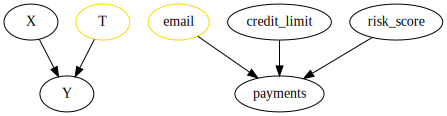

In [ ]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Mostly Harmful Controls

As a second motivating example, let's consider a drug test scenario with 2 hospitals. Both of them are conducting randomised trials on a new drug to treat a certain illness. The outcome of interest is days hospitalised. If the treatment is effective, it will lower the amount of days the patient stays in the hospital. For one of the hospitals, the policy regarding the random treatment is to give it to 90% of its patients while 10% get a placebo. The other hospital has a different policy: it gives the drug to a random 10% of its patients and 90% get a placebo. You are also told that the hospital that gives 90% of the true drug and 10% of placebo usually gets more severe cases of the illness to treat.

In [ ]:
hospital = pd.read_csv('./data/hospital_treatment.csv')
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


Since you are dealing with randomized data, your first instinct is to simply run a regression of the outcome on the treatment.

In [ ]:
hosp_1 = smf.ols("days ~ treatment", data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


But you find some counterintuitive results. How can the treatment be increasing the number of days in the hospital? The answer lies in the fact that we are running 2 different experiments. Severity is positively linked with more days at the hospital and since the hospital with more severe cases also gives more of the drug, the drug becomes positively correlated with more days at the hospital. When we look at both hospitals together, we have that $E[Y_0|T=0]<E[Y_0|T=1]$, that is, the potential outcome of the untreated is, on average, lower than that of the treated because there are more untreated in the hospital with less severe cases. In other words, severity acts as a confounder, determining the hospital the patient goes and, hence, the probability of receiving the drug.

There are 2 ways of fixing that. The first one, which defeats the purpose of using data from both hospitals, is to simply look at the ATE in each hospital individually.

In [ ]:
hosp_2 = smf.ols("days ~ treatment", data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [ ]:
hosp_3 = smf.ols("days ~ treatment", data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


In this case, we did get an intuitive result of the ATE. It looks like now the drug is in fact lowering the amount of days at the hospital. However, since we are looking at each hospital individually, there are not enough data points. As a consequence, we are unable to find statistically significant results.

The other approach, which leverages the power of regression, is to control for severity by including it in the model.

In [ ]:
hosp_4  =smf.ols("days ~ treatment + severity", data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


The question that arises next is, should we also include hospital in the model? After all, we know that hospitals cause the treatment right? Well, that is true, but once we've controlled for severity, hospital is no longer correlated with the outcome number of days hospitalised. And we know that to be a confounder a variable has to cause both the treatment and the outcome. In this case, we have a variable that only causes the treatment.

But maybe controlling for it lowers the variance, right? Well, not true again. In order for a control to lower the variance, it has to be a good predictor of the outcome, not of the treatment, which is the case here.

Still, we might want to control it right? It can't hurt... Or can it?

In [ ]:
hosp_5 = smf.ols("days ~ treatment + severity + hospital", data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


Surprisingly, it can hurt!

Adding hospital on top of severity as a control introduced MORE variance to our ATE estimator. How can that be? The answer lies in the formula for the standard error of the regression coefficient.

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

From this formula, we can see that the standard error is inversely proportional to the variance of the variable $X$. This means that, if $X$ doesn't change much, it will be hard to estimate its effect on the outcome. This also makes intuitive sense. Take it to the extreme and pretend you want to estimate the effect of a drug, so you conduct a test with 10000 individuals but only 1 of them get the treatment. This will make finding the ATE very hard, we will have to rely on comparing a single individual with everyone else. Another way to say this is that we need lots of variability in the treatment to make it easier to find its impact.

As to why including hospitals in the model increases the error of our estimate, it is because it is a good predictor of the treatment and not of the outcome (once we control for severity). So, by predicting the treatment, it effectively makes it so that it's variance is lower! Once again, we can resort to partitioning our regression above into it's 2 steps to see this.

In [ ]:
model_treatment = smf.ols("treatment ~ severity + hospital", data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.828e-14,0.827,4.63e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [ ]:
print("Treatment Variance:", np.var(hospital["treatment"]))
print("Treatment Residual Variance:", np.var(residuals["res_treatment"]))

Treatment Variance: 0.234375
Treatment Residual Variance: 0.05752909187211909


Also, don't take my word for it! You can check that the SE formula above is true:

In [ ]:
sigma_hat = sum(model_treatment.resid**2) / len(model_treatment.resid-2)
var = sigma_hat / sum((residuals['res_treatment'] - residuals['res_treatment'].mean())**2)
print('SE of the Coefficient:', np.sqrt(var))

SE of the Coefficient: 3.40361388084772


So the bottom line is that we should add controls that are both correlated with the treatment and the outcome (confounder), like the severity in the model above. We should also add controls that are good predictors of the outcome, even if they are not confounders, because they lower the variance of our estimates. However, we should **NOT** add controls that are just good predictors of the treatment, because they will increase the variance of our estimates.

Here is a picture of what this situation looks like with causal graphs.

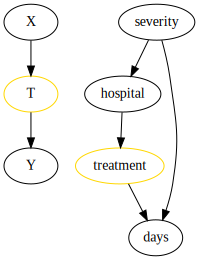

In [ ]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## Bad Controls - Selection Bias

Let's go back to the collections email example. Remember that the email was randomly assigned to customers. We've already explained what `credit_limit` and `risk_score` is. Now, let's look at the remaining variables. `opened` is a dummy variable for the customer opening the email or not. `agreement` is another dummy marking if the customers contacted the collections department to negotiate their debt, after having received the email. Which of the following models do you think is more appropriate? The first is a model with the treatment variable plus `credit_limit` and `risk_score`; the second adds `opened` and `agreement` dummies.

In [ ]:
email_1 = smf.ols("payments ~ email + credit_limit + risk_score", data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [ ]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


While the first model finds statistically significant results for the email, the second one does not. But maybe the second one is the right model and there's no effect for the email. After all, this model controls for more factors, so it should be more robust right? By now you probably know that this is not the case. What is left is to figure out what is.

We know that we MUST add confounding variables. Variables that cause both the treatment and the outcome. We also know that it is a good idea to add controls that predict the outcome very well. This is not required, but it's nice to have. We also know that it is a bad idea to add controls that predict only the treatment. Again, this is not a deadly sin, but is nice to avoid. So what kind of controls are `opened` and `agreement`? Turns out, they are neither of the above.

If you think about it, `opened` and `agreement` are surely correlated with the email. After all, you can't open the email if you didn't receive it and we've also said that the agreement only considers renegotiation that happened after the email has been sent. But **they don't cause email! Instead, they are caused by it!**

Whenever I need to understand what kind of variables I'm dealing with, I always like to think about their causal graph. Let's do these here

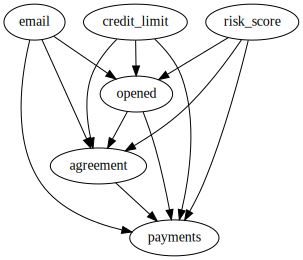

In [ ]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

We know nothing causes email, because it's random by design. And we know (or at least we have strong reasons to believe) that credit limit and risk cause payments. We also think that email causes payments. As for `opened`, we think that it does cause payments. Intuitively, people that opened the collection email are more willing to negotiate and pay their debt. We also think that `opened` causes agreements for the same reasons as it causes payments. Moreover, we know `opened` is caused by email and we have reasons to believe people with different risk and credit limits have different open rates for the emails, so credit limit and risk also causes opened. As for agreement, we also think that it is caused by `opened`. If we think about the payments response variable, we can think of is as the result of a funnel:

$
email -> opened -> agreement -> payment
$

We also think that different levels of risk and line have different propensity of doing an agreement, so we will mark them as also causing agreement. As for email and agreement, we could make an argument that some people just read the subject of the email and that makes them more likely to make an agreement. The point is that email could also cause agreement without passing through open.

What we notice with this graph is that opened and agreement are both in the causal path from email to payments. So, if we control for them with regression, we would be saying "this is the effect of email while keeping `opened` and `agreement` fixed". However, both are part of the causal effect of the email, so we don't want to hold them fixed. Instead, we could argue that email increases payments precisely because it boosts the agreement rate. If we fix those variables, we are removing some of the true effect from the email variable.

With potential outcome notation, we can say that, due to randomization $E[Y_0|T=0] = E[Y_0|T=1]$. However, even with randomization, when we control for agreement, treatment and control are no longer comparable. In fact, with some intuitive thinking, we can even guess how they are different:


$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

The first equation makes it explicit that we think those without the email and the agreement are better than those with the email and without the agreement. That is because, if the treatment has a positive effect, those that didn't make an agreement **even after having received the email** are probably worse in terms of payments compared to those that also didn't do the agreement but also didn't get the extra incentive of the email. As for the second equation, those that did the agreement even without having received the treatment are probably better than those that did the agreement but had the extra incentive of the email.

This might be very confusing the first time you read it (it was for me), but make sure you understand it. Read it again if necessary. Then, a similar kind of reasoning can be done with the opened variable. Try to make it yourself.

This sort of bias is so pervasive it has its own name. While confounding is the bias from failing to control for a common cause, **selection bias is when we control for a common effect or a variable in between the path from cause to effect.** As a rule of thumb, always include confounders and variables that are good predictors of $Y$ in your model. Always exclude variables that are good predictors of only $T$, mediators between the treatment and outcome or common effect of the treatment and outcome.

# 08 - Instrumental Variables

## Going Around Omitted Variable Bias

One way to control for OVB is, well, adding the omitted variable into our model. However, that is not always possible, mostly because we simply don't have data on the omitted variables. For instance, let's go back to our model for effect of education on wage:

$
\log(\mathrm{wage})_i = \beta_0 + \kappa \ \mathrm{educ}_i + \pmb{\beta}\mathrm{Ability}_i + u_i
$

To figure out the causal effect of education $\kappa$ on $\log\mathrm{(wage)}$ we need to control for ability factors $\mathrm{Ability}_i$. If we don't, we would likely have some bias, after all, ability is probably a confounder, causing both the treatment, education, and the outcome, earnings.

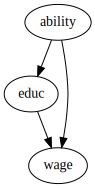

In [91]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

One way to avoid this is to control for constant levels of ability when measuring the effect of education on wage. We could do that by including ability in our linear regression model. However, we don't have good measurements of ability. The best we have are some very questionable proxies, like IQ.

But all is not lost. Here is where Instrumental Variables enters the picture. The idea of IV is to find another variable that causes the treatment and it is only correlated with the outcome through the treatment. Another way of saying this is that this instrument $Z_i$ is uncorrelated with $Y_0$, but it is correlated with $T$. This is sometimes referred to as the exclusion restriction.

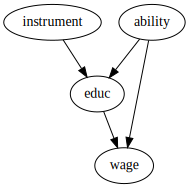

In [ ]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

If we have such a variable, we can recover the causal effect $\kappa$ with what we will see as the IV formula. To do so, let's think about the ideal equation we want to run. Using more general terms like $T$ for the treatment and $W$ for the confounders, here is what we want:

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

However, we don't have data on $W$, so all we can run is

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

Since $W$ is a confounder, $\mathrm{Cov}(T, v) \neq 0$. We have a short, not long equation. In our example, this would be saying that ability is correlated with education. If this is the case, running the short regression would yield a biased estimator for $\kappa$ due to omitted variables.

Now, behold the magic of IV! Since the instrument Z is only correlated with the outcome through T, this implies that $\mathrm{Cov}(Z,v) = 0$, otherwise there would be a second path from Z to Y through W. With this in mind, we can write

$
\mathrm{Cov}(Z,Y) = \mathrm{Cov}(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa \mathrm{Cov}(Z,T) + \mathrm{Cov}(Z, v) = \kappa \mathrm{Cov}(Z,T)
$

Dividing each side by $V(Z_i)$ and rearranging the terms, we get

$
\kappa = \dfrac{\mathrm{Cov}(Y_i, Z_i)/V(Z_i)}{\mathrm{Cov}(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}}
$

Notice that both the numerator and the denominator are regression coefficients (covariances divided by variances). The numerator is the result from the regression of Y on Z. In other words, it's the "impact" of Z on Y. Remember that this is not to say that Z causes Y, since we have a requirement that Z impacts Y only through T. Rather, it is only capturing how big is this effect of Z on Y through T. This numerator is so famous it has its own name: the reduced form coefficient.

The denominator is also a regression coefficient. This time, it is the regression of T on Z. This regression captures what is the impact of Z on T and it is also so famous that it is called the 1st Stage coefficient.

Another cool way to look at this equation is in terms of partial derivatives. We can show that the impact of T on Y is equal to the impact of Z on Y, scaled by the impact of Z on T:

$
\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{\partial z}{\partial T} =  \dfrac{\partial y}{\partial T}
$

What this is showing to us is more subtle than most people appreciate. It is also cooler than most people appreciate. By writing IV like this, we are saying, "look, it's hard to find the impact of T on Y due to confounders. But I can easily find the impact of Z on Y, since there is nothing that causes Z and Y (exclusion restriction). However, I'm interested in the impact of T on Y, not Z on Y. So, I'll estimate the easy effect of Z on Y and **scale it by the effect of Z on T**, to convert the effect to T units instead of Z units".

We can also see this in a simplified case where the instrument is a dummy variable. In this case, the IV estimator gets further simplified by the ratio between 2 differences in means.

$
\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

This ratio is sometimes referred to as the **Wald Estimator**. Again, we can tell the IV story where we want the effect of T on Y, which is hard to get. So we focus on the effect of Z on Y, which is easy. By definition, Z only affects Y through T, so we can now convert the impact of Z on Y to the impact of T on Y. We do so by scaling the effect of Z on Y by the effect of Z on T.

## Quarter of Birth and the Effect of Education on Wage

So far, we've been treating these instruments as some magical variable $Z$ which have the miraculous property of only affecting the outcome through the treatment. To be honest, good instruments are so hard to come by that we might as well consider them miracles. Let's just say it is not for the faint of heart. Rumor has it that the cool kids at Chicago School of Economics talk about how they come up with this or that instrument at the bar.

Still, we do have some interesting examples of instruments to make things a little more concrete. We will again try to estimate the effect of education on wage. To do so, we will use the person's quarter of birth as the instrument Z.

This idea takes advantage of US compulsory attendance law. Usually, they state that a kid must have turned 6 years by January 1 of the year they enter school. For this reason, kids that are born at the beginning of the year will enter school at an older age. Compulsory attendance law also requires students to be in school until they turn 16, at which point they are legally allowed to drop out. The result is that people born later in the year have, on average, more years of education than those born in the beginning of the year.

If we accept that quarter of birth is independent of the ability factor, that is, it does not confound the impact of education on wage, we can use it as an instrument. In other words, we need to believe that quarter of birth has no impact on wage, other than through its impact on education. If you don't believe in astrology, this is a very compelling argument.

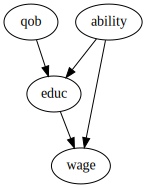

In [ ]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")

g

To perform this analysis, we can use data from three decennial census, the same data used by [Angrist and Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991) in their article about IV. This dataset has information on log wages, our outcome variable, and years of schooling, our treatment variable. It also has data on quarter of birth, our instrument, and additional controls, such as year of birth and state of birth.

In [ ]:
data = pd.read_csv('./data/ak91.csv')
data.head(9)

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0
5,5.793871,11.0,30.0,1.0,45.0
6,6.389161,11.0,30.0,1.0,36.0
7,6.047781,12.0,30.0,1.0,51.0
8,5.354861,11.0,30.0,1.0,45.0


## The 1st Stage

Before we use quarter of birth as an instrument, we need to make sure it is a valid one. This implies arguing in favor of the two Instrumental Variables assumptions:

1. $\mathrm{Cov}(Z, T) \neq 0$. This is saying that we should have a strong 1st stage, or that the instrument indeed impacts the treatment variable.
2. $Y \perp Z | T $. This is the exclusion restriction, stating that the instrument Z only affects the outcome Y through the treatment T.

The first assumption is fortunately verifiable. We can see from data that $\mathrm{Cov}(Z, T)$ is not zero. In our example, if quarter of birth is indeed an instrument like we've said, we should expect individuals born in the last quarter of the year to have slightly more time of education than those born in the beginning of the year. Before running any statistical test to verify this, let's just plot our data and see it with our own eyes.

In [ ]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])[["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

group_data.head()

,year_of_birth,quarter_of_birth,log_wage,years_of_schooling,time_of_birth
0,30.0,1.0,5.889133,12.280405,30.25
1,30.0,2.0,5.898007,12.428418,30.50
2,30.0,3.0,5.909365,12.491860,30.75
3,30.0,4.0,5.914354,12.624675,31.00
4,31.0,1.0,5.902136,12.540434,31.25


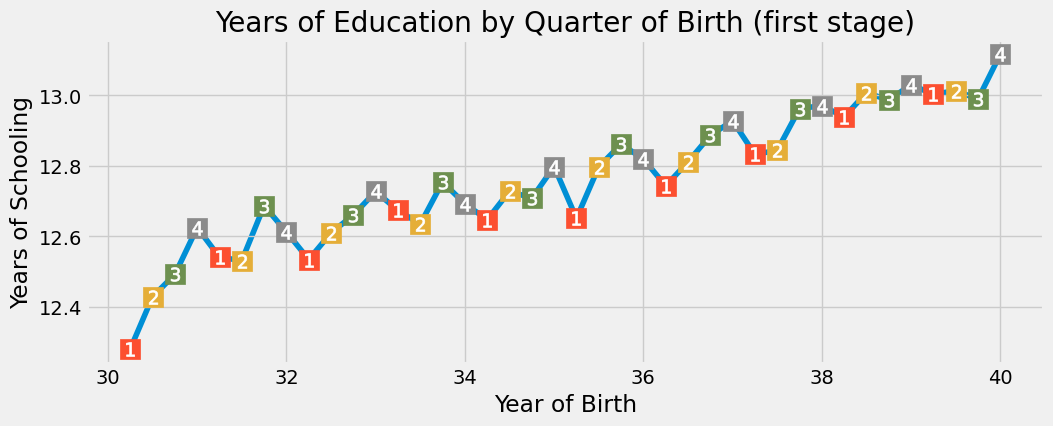

In [ ]:
plt.figure(figsize=(11,4))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

Remarkably, there is a seasonal pattern on the years of schooling that follows the quarter of the year. Visually, we can see that those born in the first quarter of the year have almost always less education than those born in the last quarter (once we control for the year of birth, after all, those born in later years have more education, in general).

To be a bit more rigorous, we can run the 1st stage as a linear regression. We will first convert the quarter of birth to dummy variables:

In [ ]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


For simplicity, let's only use the last quarter, q4, as the instrument for now. We will run a regression of years of schooling, the treatment, on quarter of birth, the instrument. This will show us if indeed quarter of birth positively affects time of education like we saw in the plot above. We also need to control for years of birth here and we will add state of birth as an additional control.

In [ ]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:", first_stage.params["q4"])
print("q4 p-value:", first_stage.pvalues["q4"])

q4 parameter estimate: 0.10085809272787055
q4 p-value: 5.464829416599837e-15


It looks like those born in the last quarter of the year have, on average, 0.1 more years of education than those born in other quarters of the year. The p-value is close to zero. This closes the case on whether quarter of birth causes more or less years of schooling.

## The Reduced Form

Unfortunately, we can't verify the second IV condition. We can only argue in favor of it. We can express our belief that quarter of birth does not influence potential earnings. In other words, the time people are born is not an indication of their personal ability or any other factor that can cause a difference in earnings, other than the effect on education. A good way of doing that is to say that the quarter of birth is as good as randomly assigned when we are thinking about it's impact on earnings. (It isn't random. There is evidence that people tend to conceive around the end of the summer or around some sort of holiday. But I can't think of any good reason that this pattern also affects income in any way other than through education).

Having argued in favor of the exclusion restriction, we can proceed to run the reduced form. The reduced form aims at figuring out how the instrument influences the outcome. Since, by assumption, all this influence is due to the effect on treatment, this will shed some light into how the treatment affects the outcome. Once again, let's evaluate this visually before getting serious with regression.

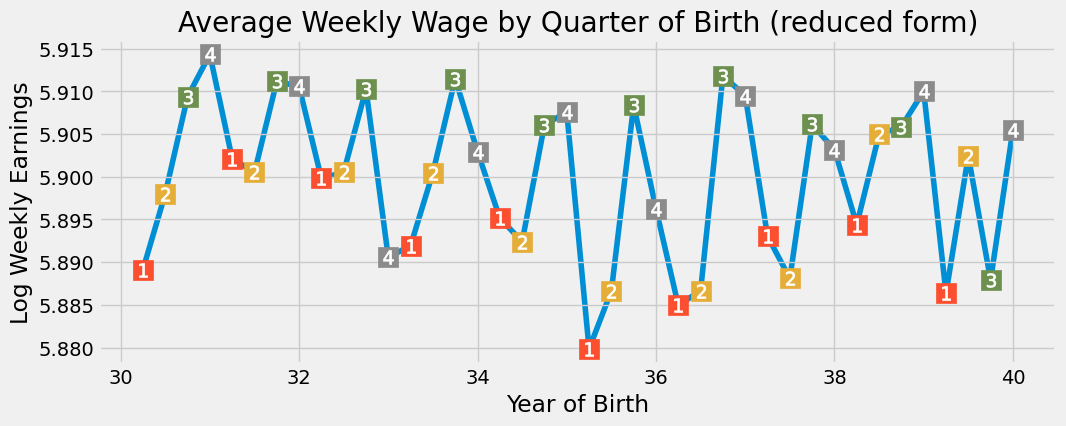

In [ ]:
plt.figure(figsize=(11,4))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

Once again, we can see a seasonal pattern on earnings by the quarter of birth. Those born later on the year have slightly higher income than those born in the beginning of the year. To test this hypothesis, we will again regress the instrumental q4 on log wage. We will also add the same additional controls as in the 1st stage:

In [ ]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:", reduced_form.params["q4"])
print("q4 p-value:", reduced_form.pvalues["q4"])

q4 parameter estimate: 0.008603484260141542
q4 p-value: 0.001494912718363033


Once again, we have a significant result. Those born in the last quarter of the year have, on average, 0.8% higher wages. This time, the p-value is not so close to zero as before, but it's still pretty significant, being just 0.0015.

## Instrumental Variables by Hand

Having both our reduced form and our 1st stage, we can now scale the effect of the first stage by the reduced form. Since the first stage coefficient was something like 0.1, this will multiply the effect of the reduced form coefficient by almost 10. This will give us our unbiased IV estimate of the average causal effect:

$
\mathrm{ATE}_{IV} = \dfrac{\text{Reduced Form}}{\text{1st Stage}}
$

In [ ]:
reduced_form.params["q4"] / first_stage.params["q4"]

np.float64(0.08530286492086424)

This means that we should expect each additional year of school to increase wages by 8%.

Another way to get the IV estimates is by using 2 stages least squares, **2SLS**. With this procedure, we do the first stage like before and then run a second stage where we replace the treatment variable by the fitted values of the 1st stage

$
\mathrm{educ}_i = \gamma_0 + \gamma_1 \times \mathrm{q4}_i + \gamma_2\times \mathrm{yob}_i + \gamma_3\times \mathrm{sob}_i + v_i
$

$
\log(\mathrm{wage})_i = \beta_0 + \beta_1\times \mathrm{educ}_i + \beta_2\times \mathrm{yob}_i + \beta_3\times \mathrm{sob}_i + u_i
$

$
\log(\mathrm{wage})_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 \times \mathrm{q4}_i + \gamma_2\times \mathrm{yob}_i + \gamma_3\times \mathrm{sob}_i + v_i ]  + \beta_2\times \mathrm{yob}_i + \beta_3\times \mathrm{sob}_i + u_i
$

One thing to notice is that **any additional control we add to the second stage should also be added to the first stage when doing IV**.

In [ ]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

np.float64(0.0853028649208978)

As you can see, the parameters are exactly the same. This second way of looking at IV can be useful for the intuition it gives. In 2SLS, the first stage creates a new version of the treatment that is purged from omitted variable bias. We then use this purged version of the treatment, the fitted values of the 1st stage, in a linear regression.  

In practice, however, we don't do IV by hand. Not because it is troublesome, but because the standard errors we get from this second stage are a bit off. Instead, we should always let the machine do the job for us. In Python, we can use the library [linearmodels](https://bashtage.github.io/linearmodels/) to run 2SLS the right way.

The formula for 2SLS is a bit different. We should add the first stage between \[ \] inside the formula. In our case, we add `years_of_schooling ~ q4`. Additional controls don't need to be added to the first stage because the computer will do this automatically if we include them in the second stage. For this reason, we add `year_of_birth` and `state_of_birth` outside the formula of the 1st stage.

In [ ]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se, 1.96*se) + param}")
    print(f"P-value: {p_val}")

formula = "log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]"
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286490232158
SE: 0.02554081281624618
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914692265902


Once again, we can see that the parameter is exactly the same as the ones we've got before. The extra benefit is that we have valid standard errors now. With this at hand, we can say that we expect 1 extra year of education to increase wages by 8.5%, on average.

## Multiple Instruments

Another advantage of using the computers is to run 2SLS is that it is easy to add multiple instruments. In our example, we will use all quarter of birth dummies as instruments for years of schooling.

In [ ]:
formula = "log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]"
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()

parse(iv_many_zs)

Parameter: 0.1076937048894525
SE: 0.019557149011303367
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


With all 3 dummies, the estimated return on education is now 0.1, which means that we should expect a 10% average increase on earnings for every additional year of education. Let's compare this with the traditional OLS estimate. To do that, we can use 2SLS again, but without the 1st stage now.

In [ ]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()

parse(ols)

Parameter: 0.06732572817658422
SE: 0.00038839984390486644
95 CI: [0.06656446 0.06808699]
P-value: 0.0


The return on education is estimated to be lower with OLS than with 2SLS. This suggests that OVB might not be as strong as we first though. Also, notice the confidence intervals. 2SLS has a much wider CI than the OLS estimate. Let's explore this further

## Weakness of Instruments

When dealing with IV, we need to remember we are estimating the ATE indirectly. Our estimates depend on both the first stage and the second stage. If the impact of the treatment on the outcome is indeed strong, the second stage will also be strong. However, it doesn't matter how strong the second stage is if we have a weak first stage. A weak first stage means that the instrument has only a very small correlation with the treatment. Therefore, we can't learn much about the treatment from the instrument.

The formulas for the IV standard errors are a bit complex and not so intuitive, so we will try something else to grasp this problem. We will simulate data where we have a treatment T with effect 2.0 on the outcome Y, an unobserved confounder U and an additional control X. We will also simulate multiple instruments with different strengths on the 1st stage.

$$
\begin{align}
X \sim & N(0, 2^2)\\
U \sim & N(0, 2^2)\\
T \sim & N(1+0.5U, 5^2)\\
Y \sim & N(2+ X - 0.5U + 2T, 5^2)\\
Z \sim & N(T, \sigma^2) \text{ for }\sigma^2 \text{ in 0.1 to 100}
\end{align}
$$

In [110]:
np.random.seed(12)

n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(X=X, U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head(11)

,X,U,T,Y,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,...,Z_40,Z_41,Z_42,Z_43,Z_44,Z_45,Z_46,Z_47,Z_48,Z_49
0,0.945972,2.696148,8.056988,18.388910,8.233315,9.028779,16.430365,7.348864,4.848165,1.567900,...,50.836515,-121.965878,-9.118833,-42.297891,17.015717,51.777219,78.678074,-164.581598,-117.798705,-13.485292
1,-1.362852,2.570240,0.245067,2.015052,0.455988,-0.901285,-6.442245,-2.824902,7.327944,-9.643833,...,29.966537,141.855092,79.040440,66.249629,-23.107153,25.007034,-73.621303,85.867339,-209.727577,-70.792948
2,0.484879,0.664741,5.597510,11.939170,5.528384,6.148148,10.141348,18.923875,-5.550785,4.495364,...,-29.051441,14.537511,-95.846490,-117.922132,43.194916,58.534855,119.820024,-173.513340,60.562232,47.619414
3,-3.401471,1.037725,0.493532,-5.077869,0.382075,0.790127,-2.753808,3.146698,-7.152174,-6.322238,...,-61.446478,26.719702,-40.753912,63.725307,22.462409,97.200099,-116.309759,-26.328707,78.136513,-108.322304
4,1.506286,-2.590591,-6.263014,-6.460508,-6.197533,-5.954731,-19.295207,-11.343303,-7.231806,5.556399,...,-28.071993,146.111732,-21.991256,88.258432,62.211154,-72.066362,51.848504,-117.858043,78.776566,-80.547214
5,-3.069443,0.224471,0.019736,-3.911331,-0.079593,5.122394,-3.151322,0.594123,7.708525,-12.691646,...,132.026914,58.557658,-11.168108,169.286153,-6.839544,137.455018,172.907265,56.752031,-68.787230,-9.209779
6,0.010254,1.033031,2.990783,6.248097,3.071658,3.553172,0.604500,0.228263,-5.148990,-12.007611,...,120.928411,153.499517,-80.439118,-47.339622,42.491067,-54.992237,33.635662,56.619746,-192.415397,97.840482
7,-0.240455,0.918193,1.362559,5.888402,1.349048,1.753614,-7.494697,-3.694768,7.305594,5.562805,...,113.788885,84.113454,-36.006360,-221.685193,-110.908777,98.509743,-15.841010,77.915024,-148.858679,-46.637034
8,-1.613964,2.045489,-5.406963,-9.924006,-5.376030,-6.781052,-3.085990,-0.145026,-3.680479,9.048231,...,-21.415438,-18.193428,-118.321426,6.098127,168.114654,45.994458,-168.141045,148.347738,61.348534,105.051671
9,5.743639,2.498092,9.131567,24.588595,9.207021,6.094268,6.679267,14.316191,15.196781,23.293963,...,78.635679,38.092981,-258.724318,-109.757392,71.203594,112.921136,128.912696,12.757031,-62.050482,-17.509255


Just to double check, we can see that the correlation between Z and T is indeed decreasing.

In [ ]:
corr = (sim_data.corr()["T"][lambda d: d.index.str.startswith("Z")])

corr.head()

,T
Z_0,0.999807
Z_1,0.919713
Z_2,0.773434
Z_3,0.634614
Z_4,0.523719


Now, we will run one IV model per instrument we have and collect both the ATE estimate and the standard error.

In [ ]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

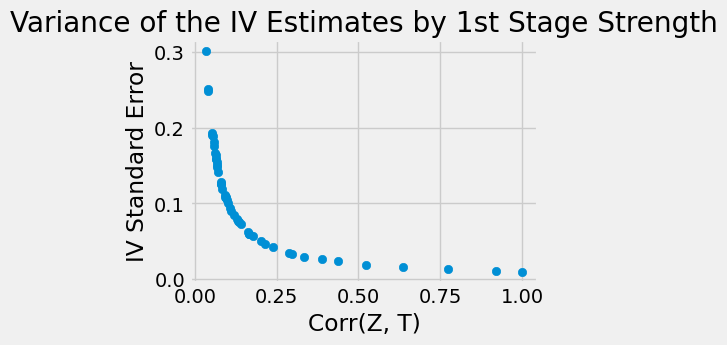

In [ ]:
plt.figure(figsize=(4,3))
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel('Corr(Z, T)')
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

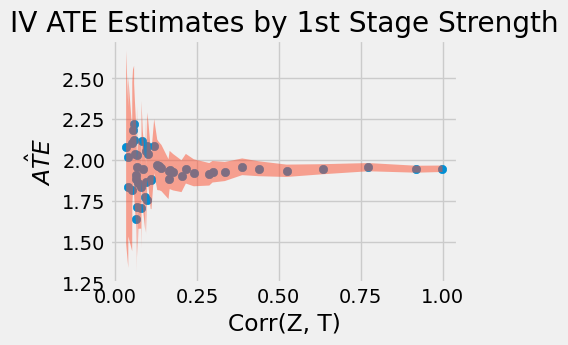

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");

# 09 - Non Compliance and LATE

## Dipping our Toes into a Heterogeneous World

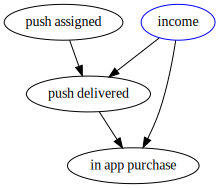

In [ ]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")

g

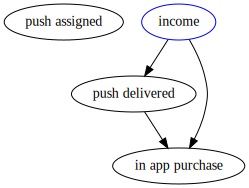

In [ ]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")

g

## Local Average Treatment Effect: LATE

## Effect on Engagement


In [ ]:
data = pd.read_csv('./data/app_engagement_push.csv')

data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


First, let's run OLS to see what it would give us.

In [ ]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()

ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


OLS is saying that the treatment effect is BRL 27.60, that is, the push increases in-app purchase by 27.6 reais. However, we have reasons to believe this is a biased estimate. We know that older phones are having trouble in receiving the push, so, probably, richer customers, with newer phones, are the compliers. Since the ones that get the treatment also have more money, we believe this bias is positive and the true impact of the push is lower. In other words, we probably have $E[Y_0|T=0] < E[Y_0|T=1]$.

Now, let's try to estimate this effect with Instrumental Variables. First, let's run the first stage.

In [ ]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,1.797e-16,,,,,
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


Looks like we have a strong first stage. Those that get assigned to get the push get it 71.8% of the time. This means that we have something like 28% of never takers. We also have strong reasons to believe there are no always takers, since the intercept parameter is estimated to be zero. This means that no one get's the push if it is not assigned to it. Given the design of our experiment, this is expected.

Let's now run the reduced form:

In [ ]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


The reduced form shows that the causal effect of treatment assignment is 2.36. This means that assigning someone to receive the push increases the in-app purchase by 2.36 reais.

If we divide the reduced form by the first stage, we scale the effect of the instrument by the units of the treatment, we get $2.3636/0.7176=3.29$. Running the 2SLS, we get these same estimates, with the bonus of correct standard errors.

In [ ]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()

iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


This shows that the result with 2SLS is much lower than the one we got with OLS: 3.29 against 27.60. This makes sense, since the causal effect estimated with OLS is positively biased. We also need to remember about LATE. 3.29 is the average causal effect on compliers. Unfortunately, we can't say anything about those never takers. This means that we are estimating the effect on the richer segment of the population that have newer phones.

# 10 - Matching

## What is Regression Doing After All?

As we've seen so far, regression does an amazing job at controlling for additional variables when we do a test vs control comparison. If we have independence, $(Y_0, Y_1)\perp T | X$, then regression can identify the ATE by controlling for X. The way regression does this is kind of magical. To get some intuition about it, let's remember the case when all variables X are dummy variables. If that is the case, regression partitions the data into the dummy cells and computes the mean difference between test and control. This difference in means keeps the Xs constant, since we are doing it in a fixed cell of X dummy. It is as if we were doing $E[Y|T=1] - E[Y|T=0] | X=x$, where $x$ is a dummy cell (all dummies set to 1, for example).  Regression then combines the estimate in each of the cells to produce a final ATE. The way it does this is by applying weights to the cell proportional to the variance of the treatment on that group.

To give an example, let's suppose I'm trying to estimate the effect of a drug and I have 6 men and 4 women. My response variable is days hospitalised and I hope my drug can lower that. On men, the true causal effect is -3, so the drug lowers the stay period by 3 days. On women, it is -2. To make matters more interesting, men are much more affected by this illness and stay longer at the hospital. They also get much more of the drug. Only 1 out of the 6 men does not get the drug. On the other hand, women are more resistant to this illness, so they stay less at the hospital. 50% of the women get the drug.

In [ ]:
drug_example = pd.DataFrame(dict(
    sex=["M", "M", "M", "M", "M", "M", "W", "W", "W", "W"],
    drug=[1,1,1,1,1,0, 1,0,1,0],
    days=[5,5,5,5,5,8, 2,4,2,4],
))

drug_example

,sex,drug,days
0,M,1,5
1,M,1,5
2,M,1,5
3,M,1,5
4,M,1,5
5,M,0,8
6,W,1,2
7,W,0,4
8,W,1,2
9,W,0,4


Note that simple comparison of treatment and control yields a negatively biased effect, that is, the drug seems less effective than it truly is. This is expected, since we've omitted the sex confounder. In this case, the estimated ATE is smaller than the true one because men get more of the drug and are more affected by the illness.

In [ ]:
drug_example.query("drug==1")["days"].mean() - drug_example.query("drug==0")["days"].mean()

np.float64(-1.1904761904761898)

Since the true effect for men is -3 and the true effect for women is -2, the ATE should be

$
ATE=\dfrac{(-3*6) + (-2*4)}{10}=-2.6
$

This estimate is done by 1) partitioning the data into confounder cells, in this case, men and women, 2) estimating the effect on each cell and 3) combining the estimate with a weighted average, where the weight is the sample size of the cell or covariate group. If we had exactly the same number of men and women in the data, the ATE estimate would be right in the middle of the ATE of the 2 groups, -2.5. Since there are more men than women in our dataset, the ATE estimate is a little bit closer to the men's ATE. This is called a non-parametric estimate, since it places no assumption on how the data was generated.

If we control for sex using regression, we will add the assumption of linearity. Regression will also partition the data into men and women and estimate the effect on both of these groups. So far, so good. However, when it comes to combining the effect on each group, it does not weigh them by the sample size. Instead, regression uses weights that are proportional to the variance of the treatment in that group. In our case, the variance of the treatment in men is smaller than in women, since only one man is in the control group. To be exact, the variance of T for men is $0.139=1/6*(1 - 1/6)$ and for women is $0.25=2/4*(1 - 2/4)$. So regression will give a higher weight to women in our example and the ATE will be a bit closer to the women's ATE of -2.

In [ ]:
smf.ols("days ~ drug + C(sex)", data=drug_example).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.5455,0.188,40.093,0.000,7.100,7.990
C(sex)[T.W],-3.3182,0.176,-18.849,0.000,-3.734,-2.902
drug,-2.4545,0.188,-13.042,0.000,-2.900,-2.010


This result is more intuitive with dummy variables, but, in its own weird way, regression also keeps continuous variables constant while estimating the effect. Also with continuous variables, the ATE will point in the direction where covariates have more variance.

So we've seen that regression has its idiosyncrasies. It is linear, parametric, likes high variance features... This can be good or bad, depending on the context. Because of this, it's important to be aware of other techniques we can use to control for confounders. Not only are they an extra tool in your causal tool belt, but understanding different ways to deal with confounding expands our understanding of the problem. For this reason, I present you now the **Subclassification Estimator!**




## The Subclassification Estimator

If there is some causal effect we want to estimate, like the effect of job training on earnings, **and** the treatment is not randomly assigned, we need to watch out for confounders. It could be that only more motivated people do the training and they would have higher earnings regardless of the training. We need to estimate the effect of the training program within small groups of individuals that are roughly the same in motivation level and any other confounders we may have.

More generally, if there is some causal effect we want to estimate, but it is hard to do so because of confounding of some variables X, what we need to do is make the treatment vs control comparison within small groups where X is the same. If we have conditional independence $(Y_0, Y_1)\perp T | X$, then we can write the ATE as follows.

$
ATE = \int(E[Y|X, T=1] - E[Y|X, T=0])dP(x)
$

What this integral does is it goes through all the space of the distribution of features X, computes the difference in means for all those tiny spaces and combines everything into the ATE. Another way to see this is to think about a discrete set of features. In this case, we can say that the features X takes on K different cells $\{X_1, X_2, ..., X_k\}$ and what we are doing is computing the treatment effect in each cell and combining them into the ATE. In this discrete case, converting the integral to a sum, we can derive the subclassifications estimator


$
\hat{ATE} = \sum^K_{k=1}(\bar{Y}_{k1} - \bar{Y}_{k0}) * \dfrac{N_k}{N}
$

where the bar represent the mean of the outcome on the treated, $Y_{k1}$, and non-treated, $Y_{k0}$, at cell k and $N_{k}$ is the number of observations in that same cell. As you can see, we are computing a local ATE for each cell and combining them using a weighted average, where the weights are the sample size of the cell. In our medicine example above, this would be the first estimate, which gave us −2.6.

## Matching Estimator

The subclassification estimator isn't used much in practice (we will see why shortly, it is because of the curse of dimensionality) but it gives us a nice intuition of what a causal inference estimator should do, how it should control for confounders. This allows us to explore other kinds of estimators, such as the Matching Estimator.

The idea is very similar. Since some sort of confounder X makes it so that treated and untreated are not initially comparable, I can make them so by **matching each treated unit with a similar untreated unit**. It is like I'm finding an untreated twin for every treated unit. By making such comparisons, treated and untreated become again comparable.

As an example, let's suppose we are trying to estimate the effect of a trainee program on earnings. Here is what the trainees looks like

In [ ]:
trainee = pd.read_csv("./data/trainees.csv")
trainee.query("trainees==1")

,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100
5,6,1,23,28600
6,7,1,33,21900
7,8,1,27,28800
8,9,1,31,20300
9,10,1,26,28100


And here are the non-trainees:

In [ ]:
trainee.query("trainees==0")

,unit,trainees,age,earnings
19,20,0,43,20900
20,21,0,50,31000
21,22,0,30,21000
22,23,0,27,9300
23,24,0,54,41100
24,25,0,48,29800
25,26,0,39,42000
26,27,0,28,8800
27,28,0,24,25500
28,29,0,33,15500


If I do a simple comparison in means, we get that the trainees earn less money than those that didn't go through the program.

In [ ]:
trainee.query("trainees==1")["earnings"].mean() - trainee.query("trainees==0")["earnings"].mean()

np.float64(-4297.49373433584)

However, if we look at the table above, we notice that trainees are much younger than non trainees, which indicates that age is probably a confounder. Let's use matching on age to try to correct that. We will take unit 1 from the treated and pair it with unit 27, since both are 28 years old. Unit 2 we will pair it with unit 34, unit 3 with unit 37, unit 4 we will pair it with unit 35... When it comes to unit 5, we need to find someone with age 29 from the non treated, but that is unit 37, which is already paired. This is not a problem, since we can use the same unit multiple times. If more than 1 unit is a match, we can choose randomly between them.

This is what the matched dataset looks like for the first 7 units

In [ ]:
# make dataset where no one has the same age
unique_on_age = (trainee
                 .query("trainees==0")
                 .drop_duplicates("age"))

matches = (trainee
           .query("trainees==1")
           .merge(unique_on_age, on="age", how="left", suffixes=("_t_1", "_t_0"))
           .assign(t1_minus_t0 = lambda d: d["earnings_t_1"] - d["earnings_t_0"]))

matches.head(9)

,unit_t_1,trainees_t_1,age,earnings_t_1,unit_t_0,trainees_t_0,earnings_t_0,t1_minus_t0
0,1,1,28,17700,27,0,8800,8900
1,2,1,34,10200,34,0,24200,-14000
2,3,1,29,14400,37,0,6200,8200
3,4,1,25,20800,35,0,23300,-2500
4,5,1,29,6100,37,0,6200,-100
5,6,1,23,28600,40,0,9500,19100
6,7,1,33,21900,29,0,15500,6400
7,8,1,27,28800,23,0,9300,19500
8,9,1,31,20300,32,0,26600,-6300


Notice how the last column has the difference in earnings between the treated and its matched untreated unit. If we take the mean of this last column we get the ATET estimate while controlling for age. Notice how the estimate is now very positive, compared to the previous one where we used a simple difference in means.

In [ ]:
matches["t1_minus_t0"].mean()

np.float64(2457.8947368421054)

But this was a very contrived example, just to introduce matching. In reality, we usually have more than one feature and units don't match perfectly. In this case, we have to define some measurement of proximity to compare how units are close to each other. One common metric for this is the euclidean norm $||X_i - X_j||$. This difference, however, is not invariant to the scale of the features. This means that features like age, that take values on the tenths, will be much less important when computing this norm compared to features like income, which take the order of hundreds. For this reason, before applying the norm, we need to scale the features so that they are on roughly the same scale.

Having defined a distance measure, we can now define the match as the nearest neighbour to that sample we wish to match. In math terms, we can write the matching estimator the following way

$
\hat{ATE} = \frac{1}{N} \sum^N_{i=1} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)
$

Where $Y_{jm}(i)$ is the sample from the other treatment group which is most similar to $Y_i$. We do this $2T_i - 1$ to match both ways: treated with controls and controls with the treatment.

To test this estimator, let's consider a medicine example. Once again, we want to find the effect of a medication on days until recovery. Unfortunately, this effect is confounded by severity, sex and age. We have reasons to believe that patients with more severe conditions have a higher chance of receiving the medicine.

In [ ]:
med = pd.read_csv("./data/medicine_impact_recovery.csv")
med.head()

,sex,age,severity,medication,recovery
0,0,35.049134,0.887658,1,31
1,1,41.580323,0.899784,1,49
2,1,28.127491,0.486349,0,38
3,1,36.375033,0.323091,0,35
4,0,25.091717,0.209006,0,15


If we look at a simple difference in means, $E[Y|T=1]-E[Y|T=0]$, we get that the treatment takes, on average, 16.9 more days to recover than the untreated. This is probably due to confounding, since we don't expect the medicine to cause harm to the patient.

In [ ]:
med.query("medication==1")["recovery"].mean() - med.query("medication==0")["recovery"].mean()

np.float64(16.895799546498726)

To correct for this bias, we will control for X using matching. First, we need to remember to scale our features, otherwise, features like age will have higher importance than features like severity when we compute the distance between points. To do so, we can standardise the features.

In [ ]:
# scale features
X = ["severity", "age", "sex"]
y = "recovery"

med = med.assign(**{f: (med[f] - med[f].mean()) / med[f].std() for f in X})
med.head()

,sex,age,severity,medication,recovery
0,-0.996980,0.280787,1.459800,1,31
1,1.002979,0.865375,1.502164,1,49
2,1.002979,-0.338749,0.057796,0,38
3,1.002979,0.399465,-0.512557,0,35
4,-0.996980,-0.610473,-0.911125,0,15


Now, to the matching itself. Instead of coding a matching function, we will use the K nearest neighbour algorithm from [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). This algorithm makes predictions by finding the nearest data point in an estimation or training set.

For matching, we will need 2 of those. One, `mt0`, will store the untreated points and will find matches in the untreated when asked to do so. The other, `mt1`, will store the treated point and will find matches in the treated when asked to do so. After this fitting step, we can use these KNN models to make predictions, which will be our matches.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

treated = med.query("medication==1")
untreated = med.query("medication==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[X])),

    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[X]))
])

predicted.head()

,sex,age,severity,medication,recovery,match
0,-0.996980,0.280787,1.459800,1,31,39.0
1,1.002979,0.865375,1.502164,1,49,52.0
7,-0.996980,1.495134,1.268540,1,38,46.0
10,1.002979,-0.106534,0.545911,1,34,45.0
16,-0.996980,0.043034,1.428732,1,30,39.0


With the matches, we can now apply the matching estimator formula

$
\hat{ATE} = \frac{1}{N} \sum^N_{i=1} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)
$

In [ ]:
np.mean((2*predicted["medication"]-1)*(predicted["recovery"] - predicted["match"]))

np.float64(-0.9954)

Using this sort of matching, we can see that the effect of the medicine is not positive anymore. This means that, controlling for X, the medicine reduces the recovery time by about 1 day, on average. This is already a huge improvement on top of the biased estimate that predicted a 16.9 increase in recovery time.

However, we can still do better.


## Matching Bias

It turns out the matching estimator as we've designed above is biased. To see this, let's consider the ATET estimator, instead of the ATE, just because it is simpler to write. The intuition will apply to the ATE as well.

$
\hat{ATET} = \frac{1}{N_1}\sum (Y_i - Y_j(i))
$

where $N_1$ is the number of treated individuals and $Y_j(i)$ is the untreated match of treated unit i. To check for bias, what we do is hope we can apply the Central Limit Theorem so that this down there converges to a normal distribution with mean zero.

$
\sqrt{N_1}(\hat{ATET} - ATET)
$

However, this doesn't alway happen. If we define the mean outcome for the untreated given X, $\mu_0(x)=E[Y|X=x, T=0]$, we will have that (btw, I've omitted the proof for that because it's a little beyond the point here).

$
E[\sqrt{N_1}(\hat{ATET} - ATET)] = E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))]
$

Now, $\mu_0(X_i) - \mu_0(X_j(i))$ is not so simple to understand, so let's look at it more carefully. $\mu_0(X_i)$ is the outcome Y value of a treated unit $i$ had it not been treated. So, it is the counterfactual outcome $Y_0$ for unit i. $\mu_0(X_j(i))$ is the outcome of the untreated unit $j$ that is the match of unit $i$. So, it is also the $Y_0$ , but for unit $j$ now. Only this time, it is a factual outcome, because $j$ is in the non treated group. Now, because $j$ and $i$ are only similar, but not the same, this will likely not be zero. In other words, $X_i \approx X_j $. So, $Y_{0i} \approx Y_{0j} $.

As we increase the sample size, there will be more units to match, so the difference between unit $i$ and its match $j$ will also get smaller. But this difference converges to zero slowly. As a result $E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))]$ may not converge to zero, because the $\sqrt{N_1}$ grows faster than $(\mu_0(X_i) - \mu_0(X_j(i)))$ diminishes.

Bias arises when the matching discrepancies are huge. Fortunately, we know how to correct it. Each observation contributes $(\mu_0(X_i) - \mu_0(X_j(i)))$ to the bias so all we need to do is subtract this quantity from each matching comparison in our estimator. To do so, we can replace $\mu_0(X_j(i))$ with some sort of estimate of this quantity $\hat{\mu_0}(X_j(i))$, which can be obtained with models like linear regression. This updates the ATET estimator to the following equation

$
\hat{ATET} = \frac{1}{N_1}\sum \big((Y_i - Y_{j(i)}) - (\hat{\mu_0}(X_i) - \hat{\mu_0}(X_{j(i)}))\big)
$

where $\hat{\mu_0}(x)$ is some estimative of $E[Y|X, T=0]$, like a linear regression fitted only on the untreated sample.

In [ ]:
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreated
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X]))

     # build the bias correction term
    .assign(bias_correct = ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),

    (untreated
     .assign(match=mt1.predict(untreated[X]))
     .assign(bias_correct = ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])

predicted.head()

,sex,age,severity,medication,recovery,match,bias_correct
0,-0.996980,0.280787,1.459800,1,31,39.0,4.404034
1,1.002979,0.865375,1.502164,1,49,52.0,12.915348
7,-0.996980,1.495134,1.268540,1,38,46.0,1.871428
10,1.002979,-0.106534,0.545911,1,34,45.0,-0.496970
16,-0.996980,0.043034,1.428732,1,30,39.0,2.610159


In [ ]:
np.mean((2*predicted["medication"] - 1) * ((predicted["recovery"] - predicted["match"]) - predicted["bias_correct"]))

np.float64(-7.36266090614141)

Of course, we also need to place a confidence interval around this measurement, but enough of math theory now. In practice, we can simply use someone else's code and just import a matching estimator. Here is one from the library [causalinference](https://github.com/laurencium/causalinference).

In [ ]:
from causalinference import CausalModel

cm = CausalModel(
    Y = med["recovery"].values,
    D = med["medication"].values,
    X = med[["severity", "age", "sex"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -7.709      0.609    -12.649      0.000     -8.903     -6.514
           ATC     -6.665      0.246    -27.047      0.000     -7.148     -6.182
           ATT     -9.679      1.693     -5.717      0.000    -12.997     -6.361



# 11 - Propensity Score

## The Psychology of Growth

As versed as we are with causal inference, we've learned to see those statements with skepticism. Is it that a growth mindset causes people to achieve more? Or is simply the case that people who achieve more are prone to develop a growth mindset as a result of their success? Who came first, the egg or the chicken? In potential outcome notation, we have reasons to believe that there is bias in these statements. $Y_0|T=1$ is probably larger than $Y_0|T=0$, which means that those with a growth mindset would have achieved more even if they had a fixed mindset.

To settle things, researchers designed the [The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#). It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up the students in their college years to measure how well they've performed academically. This measurement was compiled into an achievement score and standardized. The real data on this study is not publicly available in order to preserve students' privacy. However, we have a simulated dataset with the same statistical properties provided by [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf), so we will use that instead.

Besides the treated and outcome variables, the study also recorded some other features:

* schoolid: identifier of the student's school;
* success_expect:  self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment;
* ethnicity: categorical variable for student race/ethnicity;
* gender: categorical variable for student identified gender;
* frst_in_family: categorical variable for student first-generation status, i.e. first in family to go to college;
* school_urbanicity: school-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc;
* school_mindset: school-level mean of students’ fixed mindsets, reported prior to random assignment, standardized;
* school_achievement: school achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students, standardized;
* school_ethnic_minority: school racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American, standardized;
* school_poverty: school poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line, standardized;
* school_size: total number of students in all four grade levels in the school, standardized.

In [ ]:
data = pd.read_csv('./data/learning_mindset.csv')
data.sample(5, random_state=4)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
2613,17,1,0.546090,5,8,2,0,4,1.570640,-1.021504,0.361202,1.043998,-0.470404
7036,38,0,-0.801251,6,11,2,1,3,0.309833,0.303984,0.515392,1.274088,-1.539801
5700,58,0,0.203411,5,4,2,1,1,-0.617888,-0.163619,-0.991882,-0.946657,1.063790
9920,4,0,0.897835,6,4,1,0,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4301,69,0,-0.561653,6,4,1,1,1,-0.050579,1.112420,-0.138822,-1.185513,0.998884


Although the study was randomised, it doesn't seem to be the case that this data is free from confounding. If we look at the additional features, we will notice that they vary systematically between treatment and control. One possible reason for this is that the treatment variable is measured by the student's receipt of the seminar. So, although the opportunity to participate was random, participation itself is not. We are dealing with a case of non-compliance here. One evidence of this is how the student's success expectation is correlated with the participation in the seminar. Students with higher self-reported success expectation are more likely to have joined the growth mindset seminar.

In [ ]:
data.groupby("success_expect")["intervention"].mean()

,intervention
success_expect,
1,0.271739
2,0.265957
3,0.294118
4,0.271617
5,0.311070
6,0.354287
7,0.362319


Still, let's see what the difference in means $E[Y|T=1] - E[Y|T=0]$ looks like. This will be a useful baseline to compare against.

In [ ]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


Simply comparing those with and without the intervention, we can see that the treated have an achievement score that is, on average, 0.3185 (0.4723 - 0.1538) higher than the average score (which is zero, since the score is standardized). But is this big or small? I know that interpreting standardized outcomes can be challenging, but bear with me for a moment. I think it is worth going through this because it won't be the last time you will encounter standardized scores.

The outcome variable being standardized means that it is measured in standard deviations. So, the treated are 0.3185 deviations above the untreated. That is what this means. As for if this is small or big, let's remember some stuff about the normal distribution. We know that 95% of its mass is between 2 standard deviations, leaving 2.5% on one tail and 2.5% on another. This also means that if someone is 2 standard deviations above the mean, 97.5% (95% plus the left 2.5% tail) of all the individuals are below that person. By looking at the normal CDF, we also know that about 85% of its mass is below 1 standard deviation and that 70% of its mass is below 0.5 standard deviations. Since the treated group has an average standardized score of about 0.5, this means that they fall above 70% in terms of individual achievement. Or, in other words, they are in the top 30% who achieve more. Here is what this looks like in a picture.

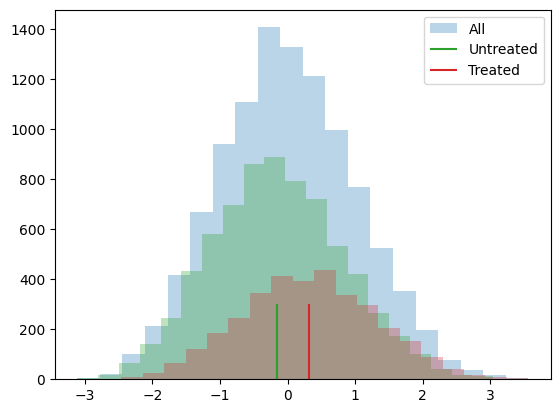

In [ ]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color='C2')
plt.hist(data.query('intervention==1')["achievement_score"], bins=20, alpha=0.3, color='C3')
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

Of course, we still think this result is biased. The difference between treated and untreated is probably smaller than this, because we think the bias is positive. We've already seen that more ambitious people are more willing to go to the seminar, so they probably would have achieved more even if they had not attended it. To control for this bias, we could use regression or matching, but it's time to learn about a new technique.


## Propensity Score

Propensity score comes from the realisation that you don't need to directly control for confounders X to achieve conditional independence $(Y_1, Y_0) \perp T | X$. Instead, it is sufficient to control for a balancing score $E[T|X]$. This balancing score is often the conditional probability of the treatment, $P(T|X)$, also called the propensity score $e(x)$. The propensity score makes it so that you don't have to condition on the entirety of X to achieve independence of the potential outcomes on the treatment. It is sufficient to condition on this single variable, which is the propensity score:

$
(Y_1, Y_0) \perp T | e(x)
$

There is a formal proof for why this is, but we can forget it for now and approach the matter in a more intuitive way. The propensity score is the conditional probability of receiving the treatment, right? So we can think of it as some sort of function that converts X into the treatment T. The propensity score makes this middle ground between the variable X and the treatment T. If we show this in a causal graph, this is what it would look like.

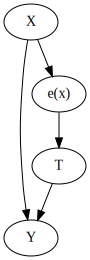

In [ ]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

## Propensity Weighting

$
E[Y|X,T=1]-E[Y|X,T=0] = E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T))
$


$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$




## Propensity Score Estimation

In an ideal world, we would have the true propensity score $e(x)$. However, in practice, the mechanism that assigns the treatment is unknown and we need to replace the true propensity score by an estimation of it $\hat{e}(x)$. One common way of doing so is using logistic regression, but other machine learning methods, like gradient boosting, can be used as well (although it requires some additional steps to avoid overfitting).

Here, I'll stick to logistic regression. This means that I'll have to convert the categorical features in the dataset to dummies.

In [ ]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethinic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

data_with_categ

,schoolid,intervention,achievement_score,success_expect,frst_in_family,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,...,ethnicity_13,ethnicity_14,ethnicity_15,gender_1,gender_2,school_urbanicity_0,school_urbanicity_1,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,76,1,0.277359,6,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
1,76,1,-0.449646,4,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
2,76,1,0.769703,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
3,76,1,-0.121763,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
4,76,1,1.526147,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,0.808867,7,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,...,False,False,False,False,True,False,False,False,True,False
10387,1,0,-0.156063,7,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,...,False,False,False,False,True,False,False,False,True,False
10388,1,0,0.370820,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,...,False,False,True,True,False,False,False,False,True,False
10389,1,0,-0.396297,5,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,...,False,False,False,True,False,False,False,False,True,False


Now, let's estimate the propensity score using logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression

T = "intervention"
Y = "achievement_score"
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315271
1,1,-0.449646,0.263482
2,1,0.769703,0.343781
3,1,-0.121763,0.343781
4,1,1.526147,0.367474


First, we can make sure that the propensity score weight indeed reconstructs a population where everyone is treated. By producing weights $1/e(x)$, it creates the population where everyone is treated and by providing the weights  $1/(1-e(x))$ it creates the population where everyone is untreated.

In [ ]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10387.611424290992
Untreated Population Sample Size 10391.506112782106


We can also use the propensity score to find evidence of confounding. If a segmentation of the population has a higher propensity score than another, it means that something which is not random is causing the treatment. If that same thing is also causing the outcome, we have confounding. In our case, we can see that students that reported to be more ambitious also have a higher probability of attending the growth mindset seminar.

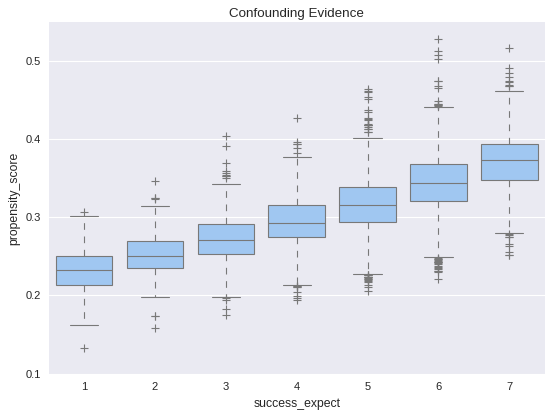

In [ ]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

We also have to check that there is overlap between the treated and untreated population. To do so, we can see the empirical distribution of the propensity score on the untreated and on the treated. Looking at the image below, we can see that no one has a propensity score of zero and that even in lower regions of the propensity score we can find both treated and untreated individuals. This is what we call a nicely balanced treated and untreated population.

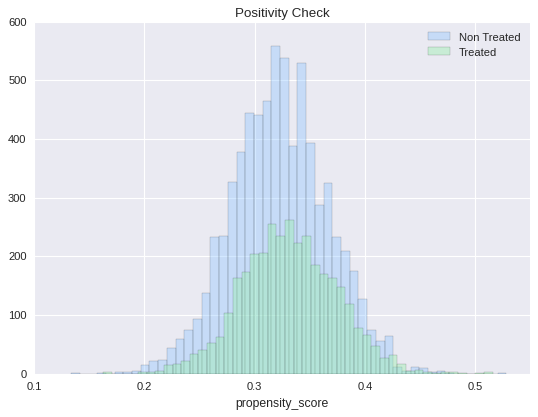

In [ ]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Finally, we can use our propensity score weighting estimator to estimate the average treatment effect.

In [ ]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0", y0)
print("ATE", ate)

Y1: 0.2598102824686926
Y0 -0.12903052827284414
ATE 0.38884081074153726


Propensity score weighting is saying that we should expect treated individuals to be 0.38 standard deviations above their untreated fellows, in terms of achievements. We can also see that if no one got the treatment, we should expect the general level of achievements to be 0.12 standard deviation lower than what it is now. By the same reasoning, we should expect the general level of achievement to be 0.25 standards deviation higher if we've given everyone the seminar. Contrast this to the 0.47 ATE estimate we've got by simply comparing treated and untreated. This is evidence that the bias we have is indeed positive and that controlling for X gives us a more modest estimate of the impact of the growth mindset.

## Standard Error

To compute the standard error for the IPTW estimator, we can use the formula of the variance of a weighted average.

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

However, we can only use this if we have the true propensity score. If we are using the estimated version of it, $\hat{P}(x)$, we need to account for the errors in this estimation process. The easiest way of doing this is by bootstrapping the whole procedure. This is achieved by sampling with replacement from the original data and computing the ATE like we did above. We then repeat this many times to get the distribution of the ATE estimate.

In [ ]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]

    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                                        for _ in range(bootstrap_sample))
ates = np.array(ates)

The ATE is then the mean of the bootstrap samples. To get confidence intervals, we can inspect the quantiles of the bootstrap distribution. For the 95% C.I., we use the 2.5 and 97.5 percentiles.

In [ ]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877403754548492
95% C.I.: (np.float64(0.35441384348333127), np.float64(0.4197524732078871))


We can also have a visual on what the bootstrap samples look like, along with the confidence intervals.

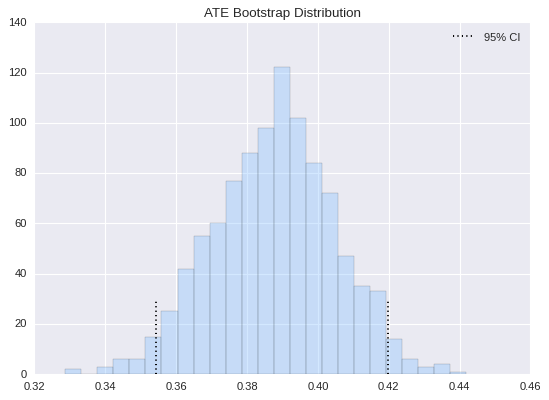

In [ ]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Common Issues with Propensity Score

The first thing is that the predictive quality of the propensity score does not translate into its balancing properties. Coming from the field of machine learning, one of the most challenging aspects of getting acquainted with causal inference is letting go of treating everything as a prediction problem. In fact, maximising the prediction power of the propensity score can even hurt the causal inference goal. **Propensity score doesn't need to predict the treatment very well. It just needs to include all the confounding variables**. If we include variables that are very good in predicting the treatment but have no bearing on the outcome this will actually increase the variance of the propensity score estimator. This is similar to the problem linear regression faces when we include variables correlated with the treatment but not with the outcome.

To see this, consider the following example (adapted from Hernán's Book). You have 2 schools, one of them apply the growth mindset seminar to 99% of its students and the other to 1%. Suppose that the schools have no impact on the treatment effect (except through the treatment), so it's not necessary to control for it. If you add the school variable to the propensity score model, it's going to have a very high predictive power. However, by chance, we could end up with a sample where everyone in school A got the treatment, leading to a propensity score of 1 for that school, which would lead to an infinite variance. This is an extreme example, but let's see how it would work with simulated data.

In [ ]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))

ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


Having simulated this data, we run bootstrap with the Propensity Score algorithm twice. The first including school as a feature to the propensity score model. The second time, we don't include school in the model.

In [ ]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

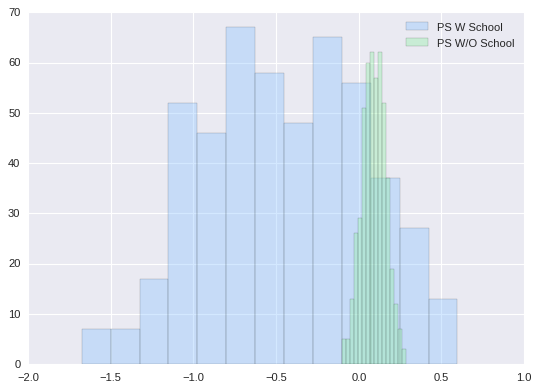

In [ ]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

As you can see, the propensity score estimator that adds the feature school has a humongous variance, while the one without it is much more well behaved. Also, since school is not a confounder, the model without it is also not biased. As I've said, simply predicting the treatment is not what this is about. We actually need to construct the prediction in a way that controls for confounding, not in a way to predict the treatment.

This leads to another problem often encountered in propensity score methods. In our mindset case, the data turned out to be very balanced. But this is not always the case. In some situations, the treated have a much higher probability of treatment than the untreated and the propensity score distribution doesn't overlap much.

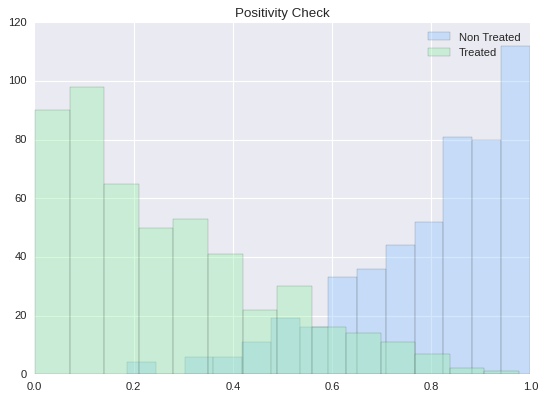

In [ ]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

If this happens, it means that positivity is not very strong. If a treated has a propensity score of, say, 0.9 and the maximum propensity score of the untreated is 0.7, we won't have any untreated to compare to the individual with the 0.9 propensity score. This lack of balancing can generate some bias, because we will have to extrapolate the treatment effect to unknown regions. Not only that, entities with very high or very low propensity scores have a very high weight, which increases variance. As a general rule of thumb, you are in trouble if any weight is higher than 20 (which happens with an untreated with propensity score of 0.95 or a treated with a propensity score of 0.05).

An alternative is clipping the weight to be at a maximum size of 20. This will decrease the variance, but it will actually generate more bias. To be honest, although this is a common practice to reduce variance, I don't really like it. You will never know if the bias you are inducing with clipping is too much. Also, if the distributions don't overlap, your data is probably not enough to make a causal conclusion anyway. To gain some further intuition about this, we can look at a technique that combines propensity score and matching

## Propensity Score Matching

As I've said before, you don't need to control for X when you have the propensity score. It suffices to control for it. As such, you can think of the propensity score as performing a kind of dimensionality reduction on the feature space. It condenses all the features in X into a single treatment assignment dimension. For this reason, we can treat the propensity score as an input feature for other models. Take a regression, model for instance.

In [ ]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0819,0.066,-46.988,0.000,-3.211,-2.953
intervention,0.3931,0.019,20.975,0.000,0.356,0.430
propensity_score,9.0700,0.200,45.244,0.000,8.677,9.463


If we control for the propensity score, we now estimate a ATE of 0.39, which is lower than the 0.47 we got previously with a regression model without controlling for the propensity score. We can also use matching on the propensity score. This time, instead of trying to find matches that are similar in all the X features, we can find matches that just have the same propensity score.

This is a huge improvement on top of the matching estimator, since it deals with the curse of dimensionality. Also, if a feature is unimportant for the treatment assignment, the propensity score model will learn that and give low importance to it when fitting the treatment mechanism. Matching on the features, on the other hand, would still try to find matches where individuals are similar on this unimportant feature.

In [ ]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values,
    D=data_ps["intervention"].values,
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.383      0.025     15.252      0.000      0.334      0.432
           ATC      0.371      0.028     13.434      0.000      0.317      0.425
           ATT      0.407      0.027     15.341      0.000      0.355      0.459



# 12 - Doubly Robust Estimation

## Don't Put All your Eggs in One Basket

We've learned how to use linear regression and propensity score weighting to estimate $E[Y|T=1] - E[Y|T=0] | X$. But which one should we use and when? When in doubt, just use both! Doubly Robust Estimation is a way of combining propensity score and linear regression in a way you don't have to rely on either of them.

To see how this works, let's consider the mindset experiment. It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up with the students in their college years to measure how well they performed academically. This measurement was compiled into an achievement score and standardised. The real data on this study is not publicly available in order to preserve students' privacy. However, we have a simulated dataset with the same statistical properties provided by [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf), so we will use that instead.

In [167]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [ ]:
data = pd.read_csv('./data/learning_mindset.csv')
data.sample(6, random_state=4)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
2613,17,1,0.546090,5,8,2,0,4,1.570640,-1.021504,0.361202,1.043998,-0.470404
7036,38,0,-0.801251,6,11,2,1,3,0.309833,0.303984,0.515392,1.274088,-1.539801
5700,58,0,0.203411,5,4,2,1,1,-0.617888,-0.163619,-0.991882,-0.946657,1.063790
9920,4,0,0.897835,6,4,1,0,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4301,69,0,-0.561653,6,4,1,1,1,-0.050579,1.112420,-0.138822,-1.185513,0.998884
2174,26,1,-0.200677,6,4,1,1,4,-0.283624,-0.588563,0.192676,-0.259910,-0.056286


Although the study was randomised, it doesn't seem to be the case that this data is free from confounding. One possible reason for this is that the treatment variable is measured by the student's receipt of the seminar. So, although the opportunity to participate was random, participation is not. We are dealing with a case of non-compliance here. One evidence of this is how the student's success expectation is correlated with the participation in the seminar. Students with higher self-reported high expectations are more likely to have joined the growth mindset seminar.

In [ ]:
data.groupby("success_expect")["intervention"].mean()

,intervention
success_expect,
1,0.271739
2,0.265957
3,0.294118
4,0.271617
5,0.311070
6,0.354287
7,0.362319


As we know by now, we could adjust for this using a linear regression or by estimating a propensity score model with a logistic regression. Before we do that, however, we need to convert the categorical variables to dummies.

In [ ]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False), # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [ ]:
data_with_categ.head()

,schoolid,intervention,achievement_score,success_expect,frst_in_family,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,...,ethnicity_13,ethnicity_14,ethnicity_15,gender_1,gender_2,school_urbanicity_0,school_urbanicity_1,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,76,1,0.277359,6,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
1,76,1,-0.449646,4,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
2,76,1,0.769703,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
3,76,1,-0.121763,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,False,True,False,False,False,False,True
4,76,1,1.526147,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,False,False,False,True,False,False,False,False,False,True


## Doubly Robust Estimation

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$


In [ ]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
T = "intervention"
Y = "achievement_score"
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

np.float64(0.3882005013927661)

Doubly robust estimator is saying that we should expect individuals who attended the mindset seminar to be 0.388 standard deviations above their untreated fellows, in terms of achievements. Once again, we can use bootstrap to construct confidence intervals.

In [ ]:
from joblib import Parallel, delayed

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000

ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                                        for _ in range(bootstrap_sample))

ates = np.array(ates)

In [ ]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (np.float64(0.35365256135743295), np.float64(0.4197861715370329))


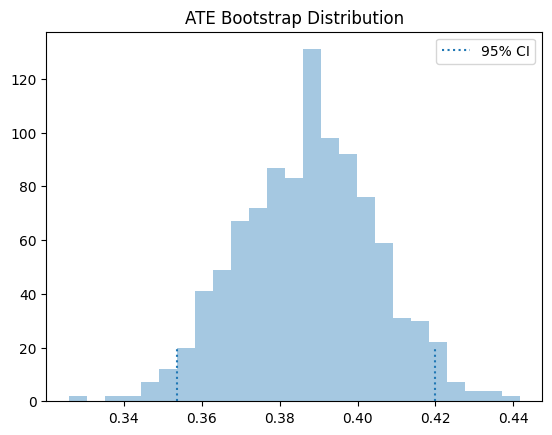

In [ ]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title('ATE Bootstrap Distribution')
plt.legend();

Now that we got a taste of the doubly robust estimator, let's examine why it is so great. First, it is called doubly robust because it only requires one of the models, $\hat{P}(x)$ or $\hat{\mu}(x)$, to be correctly specified. To see this, take the first part that estimates $E[Y_1]$ and take a good look at it.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

Assume that $\hat{\mu_1}(x)$ is correct. If the propensity score model is wrong, we wouldn't need to worry. Because if $\hat{\mu_1}(x)$ is correct, then $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$. That is because the multiplication by $T_i$ selects only the treated and the residual of $\hat{\mu_1}$ on the treated have, by definition, mean zero. This causes the whole thing to reduce to $\hat{\mu_1}(X_i)$, which is correctly estimated $E[Y_1]$ by assumption. So, you see, that by being correct, $\hat{\mu_1}(X_i)$ wipes out the relevance of the propensity score model. We can apply the same reasoning to understand the estimator of $E[Y_0]$.

But don't take my word for it. Let the code show you the way! In the following estimator, I've replaced the logistic regression that estimates the propensity score by a random uniform variable that goes from 0.1 to 0.9 (I don't want very small weights to blow up my propensity score variance). Since this is random, there is no way it is a good propensity score model, but we will see that the doubly robust estimator still manages to produce an estimation that is very close to when the propensity score was estimated with logistic regression.

In [ ]:
def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

np.float64(0.3797085235740763)

If we use bootstrap, we can see that the variance is slightly higher than when the propensity score was estimated with a logistic regression.

In [ ]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                                                 for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [ ]:
print(f'Original ATE 95% CI:', (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f'Wrong PS ATE 95% CI:', (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (np.float64(0.35365256135743295), np.float64(0.4197861715370329))
Wrong PS ATE 95% CI: (np.float64(0.33853073645584125), np.float64(0.4328333217479125))


$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

Now, assume that the propensity score $\hat{P}(X_i)$ is correctly specified. In this case, $E[T_i - \hat{P}(X_i)]=0$, which wipes out the part dependent on $\hat{\mu_1}(X_i)$. This makes the doubly robust estimator reduce to the propensity score weighting estimator $\frac{T_iY_i}{\hat{P}(X_i)}$, which is correct by assumption. So, even if the $\hat{\mu_1}(X_i)$ is wrong, the estimator will still be correct, provided that the propensity score is correctly specified.

Once again, if you believe more in code than in formulas, here it is the practical verification. In the code below, I've replaced both regression models with a random normal variable. There is no doubt that $\hat{\mu}(X_i)$ is **not correctly specified**. Still, we will see that doubly robust estimation still manages to recover the same $\hat{ATE}$ of about 0.38 that we've seen before.

In [ ]:
def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:,1]

    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

np.float64(0.3984698249166829)

Once again, we can use bootstrap and see that the variance is just slightly higher.

In [ ]:
np.random.seed(88)
prallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                                                    for _ in range(bootstrap_sample))

wrong_mux = np.array(wrong_mux)

In [ ]:
print(f'Original ATE 95% CI:', (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f'Wrong Mu ATE 95% CI:', (np.percentile(wrong_mux, 2.5), np.percentile(wrong_mux, 97.5)))

Original ATE 95% CI: (np.float64(0.35365256135743295), np.float64(0.4197861715370329))
Wrong Mu ATE 95% CI: (np.float64(0.33853073645584125), np.float64(0.4328333217479125))


Once more, messing up the conditional mean model alone yields only slightly different ATE. I hope I've convinced you about the power of doubly robust estimation. Its magic happens because in causal inference, there are two ways to remove bias from our causal estimates: you either model the treatment mechanism or the outcome mechanism. If either of these models are correct, you are good to go.

One caveat is that, in practice, it's very hard to model precisely either of those. More often, what ends up happening is that neither the propensity score nor the outcome model are 100% correct. They are both wrong, but in different ways. When this happens, it is not exactly settled [\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf) [\[2\]](https://arxiv.org/pdf/0804.2969.pdf) [\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/) if it's better to use a single model or doubly robust estimation. As for me, I still like using them because at least it gives me two possibilities of being correct.


# 13 - Difference-in-Differences


## Three Billboards in the South of Brazil

Diff-in-diff is commonly used to assess the effect of macro interventions, like the effect of immigration on unemployment, the effect of gun law changes in crime rates or simply the difference in user engagement due to a marketing campaign. In all these cases, you have a period before and after the intervention and you wish to untangle the impact of the intervention from a general trend. As a motivating example, let's look at a question similar to the one I had to answer.

In order to figure out how good billboards were as a marketing channel, we placed 3 billboards in the city of Porto Alegre, the capital of the state of Rio Grande do Sul. We wanted to see if that boosted deposits into our savings account. As a note for those not very familiar with Brazilian geography, Rio Grande do Sul is part of the south of the country, one of the most developed regions.

Having this in mind, we decided to also look at data from another capital from the south, Florianopolis, the capital city of the state of Santa Catarina. The idea is that we could use Florianopolis as a control sample to estimate the counterfactual $Y_0$ when compared to Porto Alegre (by the way, this was not the true experiment, which is confidential, but the idea is very similar). We placed the billboard in Porto Alegre for the entire month of June. The data we have looks like this:

In [ ]:
data = pd.read_csv('data/billboard_impact.csv')
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


Remember that deposits are our outcome variable, the one we wish to increase with the billboards. POA is a dummy indicator for the city of Porto Alegre. When it is zero, it means the samples are from Florianopolis. Jul is a dummy for the month of July, or for the post intervention period. When it is zero it refers to samples from May, the pre-intervention period.


## DID Estimator

To avoid confusion between Time and Treatment, from now on, I'll use D to denote treatment and T to denote time. Let $Y_D(T)$ be the potential outcome for treatment D on period T. In an ideal world where we have the ability to observe the counterfactual, we would estimate the treatment effect of an intervention the following way:

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

In words, the causal effect is the outcome in the period post intervention in case of a treatment minus the outcome in also in the period after the intervention, but in the case of no treatment. Of course, we can't measure this because $Y_0(1)$ is counterfactual.

One way around this is a before and after comparison.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

In our example, we would compare the average deposits from POA before and after the billboard was placed.

In [ ]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

np.float64(41.04775)

This estimator is telling us that we should expect deposits to increase R$ 41,04 after the intervention. But can we trust this?

Notice that $E[Y(0)|D=1]=E[Y_0(0)|D=1]$, that is, the observed outcome for the treated unit **before the intervention** is equal to the counterfactual outcome for the treated unit also before the intervention. Since we are using this to estimate the counterfactual **after the intervention**  $E[Y_0(1)|D=1]$, this estimation above assumes that $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$.

It is saying that in the case of no intervention, the outcome in the latter period would be the same as the outcome from the starting period. This would obviously be false if your outcome variable follows any kind of trend. For example, if deposits are going up in POA, $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, i.e. the outcome of the latter period would be greater than that of the starting period even in the absence of the intervention. With a similar argument, if the trend in Y is going down, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. This is to show that this before and after thing is not a great estimator.

Another idea is to compare the treated group with an untreated group that didn't get the intervention:

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

In our example, it would be to compare the deposits from POA to that of Florianopolis in the post intervention period.

In [ ]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()

poa_after - fl_after

np.float64(-119.10175000000001)

This estimator is telling us that the campaign is detrimental and that customers will decrease deposits by R$ 119.10.

Notice that $E[Y(1)|D=0]=E[Y_0(1)|D=0]$. And since we are using $E[Y(1)|D=0]$ to estimate the counterfactual for the treated after the intervention, we are assuming we can replace the missing counterfactual like this: $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$. But notice that this would only be true if both groups have a very similar baseline level. For instance, if Florianopolis has way more deposits than Porto Alegre, this would not be true because $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. On the other hand, if the level of deposits are lower in Florianopolis, we would have $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$.

Again, this is not a great idea. To solve this, we can use both space and time comparison. This is the idea of the difference in difference approach. It works by replacing the missing counterfactual the following way:

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

What this does is take the treated unit **before the intervention** and adds a trend component to it, which is estimated using the control $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$. In words, it is saying that the treated **after the intervention**, had it not been treated, would look like the **treated before the treatment** plus a growth factor that is the same as the growth of the control.

It is important to notice that this assumes that the trends in the treatment and control are the same:

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

where the left hand side is the counterfactual trend. Now, we can replace the estimated counterfactual in the treatment effect definition $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

If we rearrange the terms, we get the classical Diff-in-Diff estimator.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

It gets that name because it gets the difference between the difference between treatment and control after and before the treatment.

Here is what that looks in code.

In [ ]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)

diff_in_diff

np.float64(6.524557692307688)

Diff-in-Diff is telling us that we should expect deposits to increase by R$ 6.52 per customer. Notice that the assumption that diff-in-diff makes is much more plausible than the other 2 estimators. It just assumes that the growth pattern between the 2 cities are the same. But it doesn't require them to have the same base level nor does it require the trend to be zero.

To visualize what diff-in-diff is doing, we can project the growth trend from the untreated into the treated to see the counterfactual, that is, the number of deposits we should expect if there were no intervention.

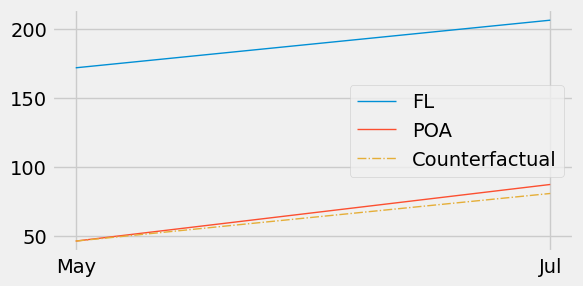

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(["May", "Jul"], [fl_before, fl_after], label='FL', lw=1)
plt.plot(["May", "Jul"], [poa_before, poa_after], label='POA', lw=1)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=1, color='C2', ls="-.")

plt.legend();

Now, what you might be asking yourself is "how much can I trust this estimator? It is my right to have standard errors reported to me!". Which makes sense, since estimators without them look silly. To do so, we will use a neat trick that uses regression. Specifically, we will estimate the following linear model

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

Notice that $\beta_0$ is the baseline of the control. In our case, is the level of deposits in Florianopolis in the month of May. If we turn on the treated city dummy, we get $\beta_1$. So $\beta_0 + \beta_1$ is the baseline of Porto Alegre in May, before the intervention, and $\beta_1$ is the increase of Porto Alegre baseline on top of Florianopolis. If we turn the POA dummy off and turn the July dummy on, we get $\beta_0 + \beta_2$, which is the level of Florianópolis in July, after the intervention period. $\beta_2$ is then the trend of the control, since we add it on top of the baseline to get the level of the control at the period post intervention. As a recap, $\beta_1$ is the increment we get by going from the control to the treated, $\beta_2$ is the increment we get by going from the period before to the period after the intervention. Finally, if we turn both dummies on, we get $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ is the level in Porto Alegre after the intervention. So $\beta_3$ is the incremental impact when you go from May to July and from Florianopolis to POA. In other words, it is the Difference in Difference estimator.

If you don't believe me, check for yourself. You should get the exact same number we got above. And also notice how we get our much wanted standard errors.

In [ ]:
smf.ols("deposits ~ poa*jul", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Non Parallel Trends

One obvious problem with Diff-in-Diff is failure to satisfy the parallel trend assumption. If the growth trend from the treated is different from the trend of the control, diff-in-diff will be biased. This is a common problem with non-random data, where the decision to treat a region is based on its potential to respond well to the treatment, or when the treatment is targeted at regions that are not performing very well. Take our marketing example. We decided to test billboards in Porto Alegre not in order to check the effect of billboards in general. The reason is simply because sales perform poorly there. Perhaps online marketing is not working there. In this case, it could be that the growth we would see in Porto Alegre without a billboard would be lower than the growth we observe in other cities. This would cause us to underestimate the effect of the billboard there.

One way to check if this is happening is to plot the trend using past periods. For example, let's suppose POA had a small decreasing trend but Florianopolis was on a steep ascent. In this case, showing periods from before would reveal those trends and we would know Diff-in-Diff is not a reliable estimator.

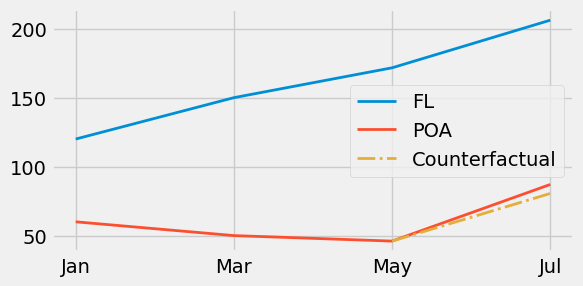

In [ ]:
plt.figure(figsize=(6,3))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

We will see how to solve this problem with synthetic control. It will use multiple cities to create a synthetic city that closely follows the trend of the city of interest. But for now, remember that you always need to check if you have parallel trends when applying diff-in-diff.

One final issue that it's worth mentioning is that you won't be able to place confidence intervals around your Diff-in-Diff estimator if you only have aggregated data. Say for instance you don't have data on what each of our customers from Florianópolis or Porto Alegre did. Instead, you only have the average deposits before and after the intervention for both cities. In this case, you will still be able to estimate the causal effect by Diff-in-Diff, but you won't know the variance of it. That's because all the variability in your data got squashed out in aggregation.



# 14 - Panel Data and Fixed Effects

In [ ]:
from linearmodels.datasets import wage_panel

## Parallel Trends

## Controlling What you Cannot See

## Fixed Effects

To make matters more formal, let's first take a look at the data that we have. Following our example, we will try to estimate the effect of marriage on income. Our data contains those 2 variables, `married` and `lwage`, on multiple individuals (`nr`) for multiple years. Notice that wage is in log form. In addition to this, we have other controls, like number of hours worked that year, years of education and so on.

In [ ]:
data = wage_panel.load()
data.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


In [ ]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


In [ ]:
data.groupby("year")["lwage"].mean()

,lwage
year,
1980,1.393477
1981,1.512867
1982,1.571667
1983,1.619263
1984,1.690295
1985,1.739410
1986,1.799719
1987,1.866479


In [ ]:
data.groupby("nr").std().sum()

,0
year,1334.971910
black,0.000000
exper,1334.971910
hisp,0.000000
hours,203098.215649
married,140.372801
educ,0.000000
union,106.512445
lwage,173.929670
expersq,17608.242825


For our data, we need to remove ethnicity dummies, `black` and `hisp`, since they are constant for the individual. Also, we need to remove education. We will also not use occupation, since this is probably mediating the effect of marriage on wage (it could be that single men are able to take more time demanding positions). Having selected the features we will use, it's time to estimate this model.

To run our fixed effect model, first, let's get our mean data. We can achieve this by grouping everything by individuals and taking the mean.

In [ ]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


To demean the data, we need to set the index of the original data to be the individual identifier, `nr`. Then, we can simply subtract one data frame from the mean data frame.

In [ ]:
demeaned_data = (data
                 .set_index("nr") # set the index as the person indicator
                 [X+[Y]]
                 - mean_data) # subtract the mean data

demeaned_data

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,-24.5,-0.125,-135.625,-0.058112
13,0.000,-21.5,0.875,-487.625,0.597408
13,0.000,-16.5,-0.125,132.375,0.088810
13,0.000,-9.5,-0.125,152.375,0.177561
13,0.000,-0.5,-0.125,263.375,0.312473
...,...,...,...,...,...
12548,0.375,-13.5,-0.375,-156.500,0.209698
12548,0.375,3.5,0.625,-156.500,-0.169638
12548,0.375,22.5,-0.375,-156.500,0.383781


Finally, we can run our fixed effect model on the time-demeaned data.

In [ ]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.852e-17,0.005,-1.35e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


If we believe that fixed effect eliminates the all omitted variable bias, this model is telling us that marriage increases a man's wage by 11%. This result is very significant. One detail here is that for fixed effect models, the standard errors need to be clustered. So, instead of doing all our estimation by hand (which is only nice for pedagogical reasons), we can use the library `linearmodels` and set the argument `cluster_entity` to True.

In [ ]:
from linearmodels.panel import PanelOLS

mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(['nr', 'year']))

result = mod.fit(cov_type="clustered", cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


Notice how the parameter estimates are identical to the ones we've got with time-demeaned data. The only difference is that the standard errors are a bit larger. Now, compare this to the simple OLS model that doesn't take the time structure of the data into account. For this model, we add back the variables that are constant in time.

In [ ]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


This model is saying that marriage increases the man's wage by 14%. A somewhat larger effect than the one we found with the fixed effect model. This suggests some omitted variable bias due to fixed individual factors, like intelligence and beauty, not being added to the model.

## Visualizing Fixed Effects

To expand our intuition about how fixed effect models work, let's diverge a little to another example. Suppose you work for a big tech company and you want to estimate the impact of a billboard marketing campaign on in-app purchase. When you look at data from the past, you see that the marketing department tends to spend more to place billboards on cities where the purchase level is lower. This makes sense right? They wouldn't need to do lots of advertisement if sales were skyrocketing. If you run a regression model on this data, it looks like higher cost in marketing leads to less in-app purchase, but only because marketing investments is biased towards low spending regions.

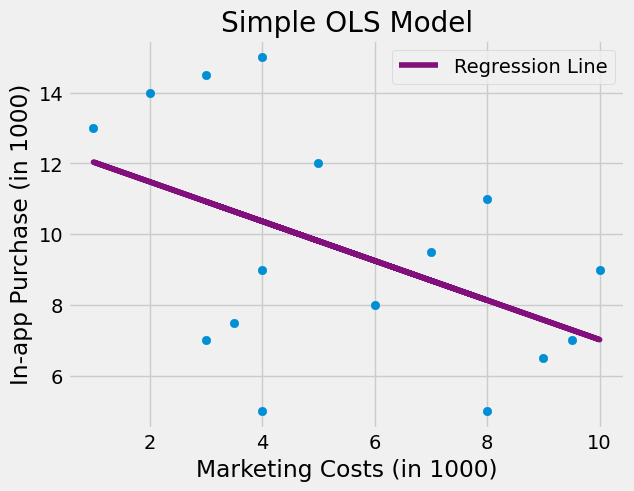

In [ ]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

Knowing a lot about causal inference, you decide to run a fixed effect model, adding the city's indicator as a dummy variable to your model. The fixed effect model controls for city specific characteristics that are constant in time, so if a city is less open to your product, it will capture that. When you run that model, you can finally see that more marketing costs leads to higher in-app purchase.

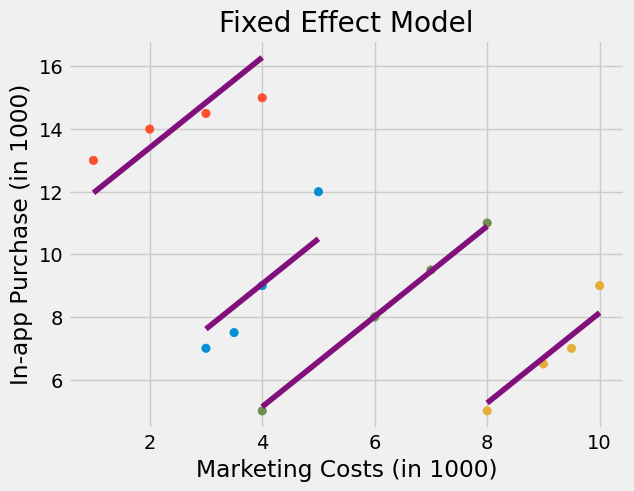

In [ ]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

Take a minute to appreciate what the image above is telling you about what fixed effect is doing. Notice that fixed effect is fitting **one regression line per city**. Also notice that the lines are parallel. The slope of the line is the effect of marketing costs on in-app purchase. So the **fixed effect is assuming that the causal effect is constants across all entities**, which are cities in this case. This can be a weakness or an advantage, depending on how you see it. It is a weakness if you are interested in finding the causal effect per city. Since the FE model assumes this effect is constant across entities, you won't find any difference in the causal effect. However, if you want to find the overall impact of marketing on in-app purchase, the panel structure of the data is a very useful leverage that fixed effects can explore.

## Time Effects

Just like we did a fixed effect for the individual level, we could design a fixed effect for the time level. If adding a dummy for each individual controls for fixed individual characteristics, adding a time dummy would control for variables that are fixed for each time period, but that might change across time. One example of such a variable is inflation. Prices and salary tend to go up with time, but the inflation on each time period is the same for all entities. To give a more concrete example, suppose that marriage is increasing with time. If the wage and marriage proportion also changes with time, we would have time as a confounder. Since inflation also makes salary increase with time, some of the positive association we see between marriage and wage would be simply because both are increasing with time. To correct for that, we can add a dummy variable for each time period. In `linear models`, this is as simple as adding `TimeEffects` to our formula and setting the `cluster_time` to true.

In [ ]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


In this new model, the effect of marriage on wage decreased significantly from `0.1147` to `0.0476`. Still, this result is significant at a 99% level, so man could still expect an increase in earnings from marriage.

# 15 - Synthetic Control

## One Amazing Math Trick to Learn What can’t be Known

When we looked at difference-in-difference, we had data on multiple customers from 2 different cities: Porto Alegre and Florianopolis. The data span 2 different time periods: before and after a marketing intervention was done in Porto Alegre to boost customer deposits. To estimate the treatment effect, we ran a regression that gave us the difference-in-difference estimator and its standard error.

For that case, we had a lot of samples, because data was disaggregated. But what if all we have is aggregated data on the city level? For instance, let's pretend all we have is the average level of deposits in both cities before and after the intervention.

|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

We would still be able to compute the Diff-in-Diff estimator

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

However, note that the sample size here is 4, which is also the number of parameters in our Diff-in-Diff models. In this case, the standard error is not well defined, so what should we do? Another problem is that Florianopolis might not be as similar to Porto Alegre as we would want to. For instance, Florianopolis is known for its beautiful beaches and easy going people while Porto Alegre is more famous for its barbecue and prairies. The problem here is that you can't ever know for sure if you are using an appropriate control group.

To work around this, we will use what is known as [**"the most important innovation in the policy evaluation literature in the last few years"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), Synthetic Controls. It is based on a simple, yet powerful idea. We don't need to find any single unit in the untreated that is very similar to the treated. Instead, we can forge our own as a combination of multiple untreated units, creating what is effectively a synthetic control. Synthetic control is so effective yet so intuitive that it even got an article published, not on a scientific journal, but on the [Washington Post](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/).

To see it in action, consider the problem of estimating the effect of cigarette taxation on its consumption. To give a bit of context, this is a question that had been debated for a long time in economics. One side of the argument says that taxes will increase the cost of cigars, which will lower its demand. The other side argues that since cigarettes cause addiction, change in their price won't change their demand by much. In economic terms, we would say that the demand for cigarettes is inelastic on price, and an increase in taxation is just a way to increase government income at the cost of smokers. To settle things, we will look at some US data regarding the matter.

In 1988, California passed a famous Tobacco Tax and Health Protection Act, which became known as [Proposition 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99). "Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles, and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements."

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the year 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.

In [186]:
cigar = (pd.read_csv('data/smoking.csv').drop(columns=['lnincome', 'beer', 'age15to24']))

cigar.query('california').head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


We have `state` as the state index, where California is the number 3. Our covariates are `retprice`, the cigarette retail price, and `cigsale`, the per-capita sales of cigarettes in packs. Our outcome variable of interest is `cigsale`. Finally, we have boolean helper variables to signal the state of California and the post intervention period. If we plot the sales of cigarettes for California and other states across time, this is what we would get.

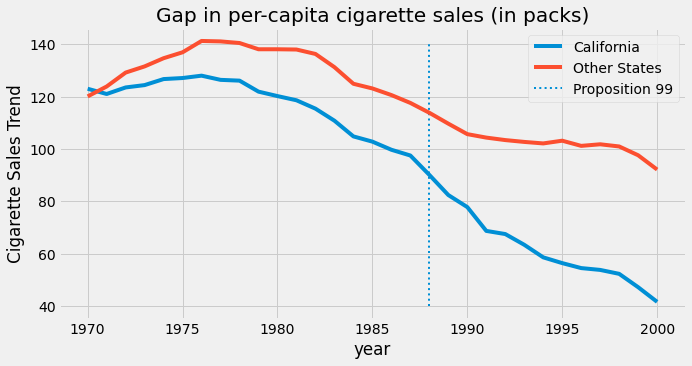

In [ ]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();

During the time for which we have data, people in California apparently bought less cigarettes than the national average. Also, it appears to be a decreasing movement in cigarette consumption after the 80s. It looks like after Proposition 99 the decreasing trend accelerated for California, compared to other states, but we can't say that for sure. It is just a guess that we have by examining the plot.

To answer the question of whether Proposition 99 had an effect on cigarette consumption, we will use the pre-intervention period to build a synthetic control. We will combine the other states to **build a fake state that resembles very closely the trend of California**. Then, we will see how this synthetic control behaves after the intervention.


## Synthetic Control as Linear Regression

To estimate the treatment effect with synthetic control, we will try to build a "fake unit" that resembles the treated unit before the intervention period. Then, we will see how this "fake unit" behaves after the intervention. The difference between the synthetic control and the unit that it mimics is the treatment effect.

To do this with linear regression, we will find the weight using OLS. We will minimise the square distance between the weighted average of the units in the donor pool and the treated unit for the pre-intervention period.

To do so, the first thing we need is to convert the units (in our case, the states) into the columns and the time into the rows. Since we have 2 features, `cigsale` and `retprice`, we will pile them on top of each other like we did in the picture above. We will build a synthetic control that looks a lot like California in the pre intervention period and see how it would behave in the post intervention period. For this reason, it is important that we select only the pre-intervention period. Here, the features seem to be on a similar scale, so we won't do anything to them. If features are in different scales, one in the thousands and another in the decimals, the bigger feature will be the most important when minimizing the difference. To avoid this, it's important to scale them first.

In [195]:
cigar

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False
...,...,...,...,...,...,...
1204,39,1996,110.300003,162.500000,False,True
1205,39,1997,108.800003,164.100006,False,True
1206,39,1998,102.900002,168.800003,False,True
1207,39,1999,104.800003,189.600006,False,True


In [196]:
features = ['cigsale', 'retprice']

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
                .pivot(index='state', columns='year')[features] # make one column per year and one row per state
                .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

Now, we can define our Y variable as the state of California and the X as the other states.

In [200]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values # other states

Then, we run a regression. Having an intercept is equivalent to adding another state where every row is 1. You can do that, but I think it's more complicated and I'll just leave it out. The regression will return the set of weights that minimize the square difference between the treated unit and the units in the donor pool.

In [201]:
from sklearn.linear_model import LinearRegression

weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

These weights show us how to build the synthetic control. We will multiply the outcome of state 1 by -0.436, of state 2 by -1.038, of state 4 by 0.679 and so on. We can achieve this with a dot product between the matrix from the states in the pool and the weights.

In [209]:
calif_synth_lr = (cigar.query('~california')
.pivot(index='year', columns='state')['cigsale']
                  .values.dot(weights_lr))

Now that we have our synthetic control, we can plot it with the outcome variable of the State of California.

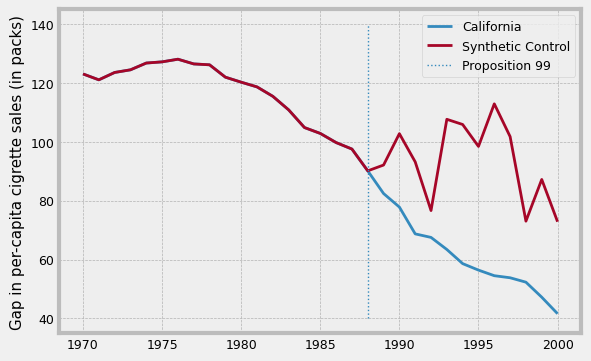

In [225]:
plt.figure(figsize=(6, 4))
plt.plot(cigar.query("california")["year"], cigar.query('california')["cigsale"], label='California')
plt.plot(cigar.query('california')["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=1, label="Proposition 99")
plt.ylabel('Gap in per-capita cigrette sales (in packs)')
plt.legend();

OK… Something seems off. What grabs your attention in this picture? First, after the intervention, the synthetic control has more cigarette sales than California. This is an indicative that the intervention was successful in lowering cigarette demand. Second, notice how the pre-intervention period is fitted perfectly. The synthetic control is able to match the state of California exactly. This is a sign that our synthetic control model is probably overfitting the data. Another sign is the huge variance on the outcome variable of the synthetic control after the intervention. Notice how it doesnt follow smooth patterns. Instead, it goes up and down and up and down.

If we think about why this is happening, remember that we have 38 states in our donor pool. So our linear regression has 38 parameters to play with in order to make the pretreatment pool match the treatment as close as it can. This is the case where, even if T is large, N is also large, which gives too much flexibility to our linear regression model. If you are familiar with regularized models, know that you could use Ridge or Lasso regression to fix this. Here, we will look at another more traditional way to avoid overfitting.

## Don't Extrapolate



In [226]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

Since we are using the same importance for every feature, we don't need to worry about $v$.

Now, to get the optimal weights, we will use the quadratic programming optimisation of scipy. We will constrain the weights to sum up to 1 with

```python
lambda x: np.sum(x) - 1
```

Also, we will set optimization bounds to be between 0 and 1.

In [227]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):

    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

With this implemented, let's get the weights that define the synthetic control

In [228]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

With this weight, we are multiplying states 1,2, and 3 by zero, state 4 by 0.0852 and
so on. Notice how the weights are sparse, exactly as we've predicted. Also, all weights sum to one and are between 0 and 1, satisfying our convex combination constraint.

Now, to get the synthetic control, we can multiply those weights by the states exactly as we did before with the regression weights.

In [229]:
calif_synth = cigar.query("~california").pivot(index='year', columns='state')['cigsale'].values.dot(calif_weights)

If we plot the outcome of the synthetic control now, we get a much smoother trend. Also notice that, in the pre intervention period, the synthetic control doesn't reproduce the treated exactly anymore. This is a good sign, as it indicates that we are not overfitting.

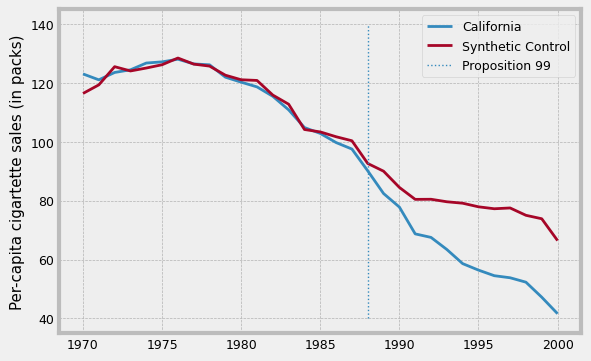

In [231]:
plt.figure(figsize=(6,4))
plt.plot(cigar.query('california')["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query('california')["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=1, label="Proposition 99")
plt.ylabel("Per-capita cigartette sales (in packs)")
plt.legend();

With the synthetic control at hand, we can estimate the treatment effect as the gap between treated and the synthetic control outcomes.

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

In our particular case, the effect gets bigger and bigger as time passes.

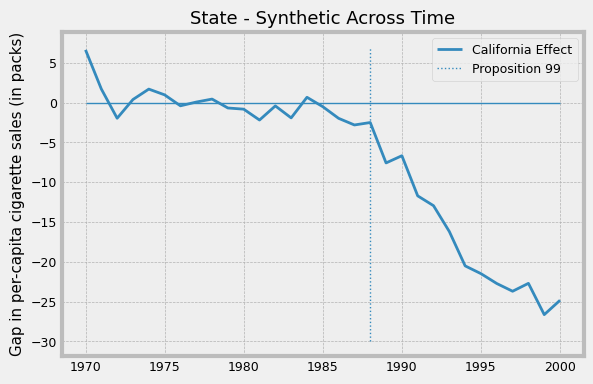

In [232]:
plt.figure(figsize=(6,4))
plt.plot(cigar.query('california')["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=1, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=1)
plt.title('State - Synthetic Across Time')
plt.ylabel('Gap in per-capita cigarette sales (in packs)')
plt.legend();

By the year 2000, it looks like Proposition 99 has reduced the sales in cigarettes by 25 packs. That is very cool and all, but something you might be asking yourself is: how can I know if this is statistically significant?

## Making Inference

Since our sample size is very small (39), we will have to be a bit smarter when figuring out if our result is statistically significant and not just due to random luck. Here, we will use the idea of Fisher's Exact Test. Its intuition is very simple. We permute the treated and control exhaustively. Since we only have one treated unit, this would mean that, for each unit, we pretend it is the treated while the others are the control.

|iteration|1|2|...|39|
|----|-|-|-|-|
|1|treated|0|0|0|
|2|0|treated|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|treated|

In the end, we will have one synthetic control and effect estimates for each state. So what this does is it pretends that the treatment actually happened for another state, not California, and see what would have been the estimated effect for this treatment that didn't happen. Then, we see if the treatment in California is sufficiently larger when compared to the other fake treatment. The idea is that for states that weren't actually treated, once we pretend they were, we won't be able to find any significant treatment effect.

To implement this, I've built this function that takes as input a state and estimate the synthetic control for that state. This function returns a data frame with one column for the state, one for the year, one for the outcome `cigsale` and the synthetic outcome for that state.

In [233]:
def synthetic_control(state:int, data:pd.DataFrame) -> np.array:

    features = ["cigsale", "retprice"]

    inverted = (data.query("~after_treatment")
                    .pivot(index='state', columns='year')[features].T)

    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                    .pivot(index="year", columns='state')['cigsale']
                    .values.dot(weights))

    return (data.query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
                       .assign(synthetic=synthetic))

Here is the result of it when we apply it to the first state.

In [234]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


To get the result for all the state, we parallelize the computation across 8 processes. If your computer has more or less cores, you can use a different number. This code will return a list of data frames like the one above.

In [235]:
from joblib import Parallel, delayed

control_pool = cigar['state'].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [236]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


With the synthetic control for all the states, we can estimate the gap between the synthetic and the true state for all states. For California, this is the treatment effect. For the other states, this is like a placebo effect, where we estimate the synthetic control treatment effect where the treatment didn't actually happen. If we plot all the placebo effects along with the California treatment effect, we get the following figure.

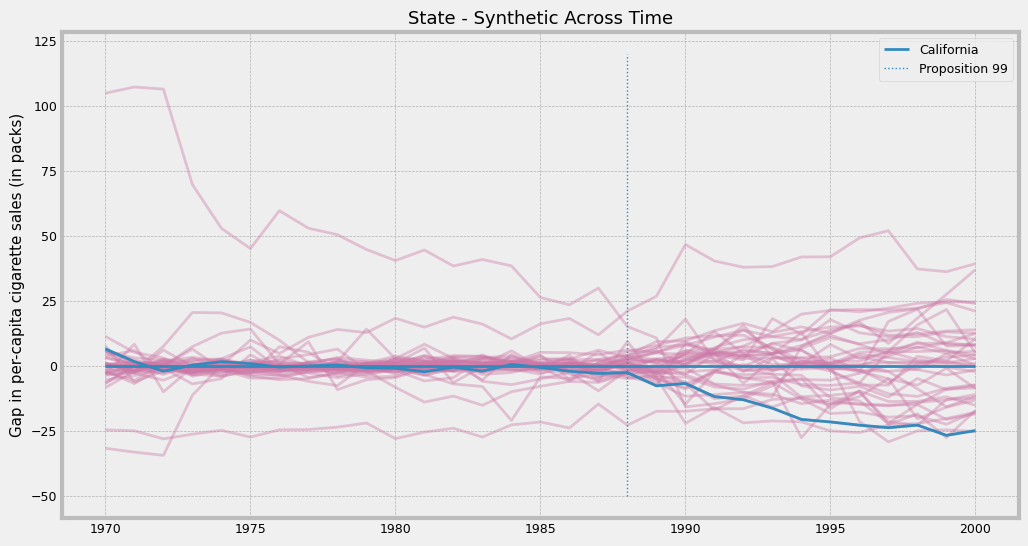

In [237]:
plt.figure(figsize=(11, 6))
for state in synthetic_states:
    plt.plot(state['year'], state['cigsale'] - state['synthetic'], color='C5', alpha=0.4)

plt.plot(cigar.query('california')["year"], cigar.query('california')["cigsale"] - calif_synth, label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=1, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.ylabel('Gap in per-capita cigarette sales (in packs)')
plt.title('State - Synthetic Across Time')
plt.legend();

Two aspects of this figure jump to the eyes. First, we can see that the variance after the intervention is higher than the variance before the intervention. This is expected, since the synthetic control is designed to minimize the difference in the pre-intervention period. Another interesting aspect is that there are some units we can't fit very well even in the pre-intervention period. This is also to be expected. For example, if some states have very high cigarette consumption, no convex combination of the other states will ever match them.

Since those units are so poorly fit, it is a good idea to remove them from the analysis. One way to do it objectively is to set a threshold for pre-intervention error

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

and remove those units with high error. If we proceed like this and plot the same figure, this is what we get.

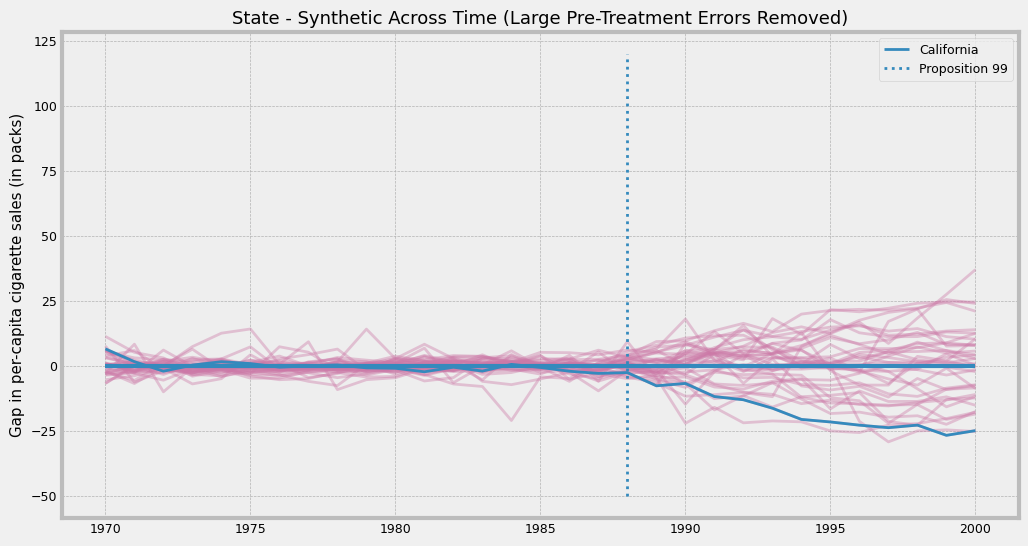

In [239]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"]
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(11, 6))
for state in synthetic_states:

    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5", alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth, label="California")

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

Removing the noise, we can see how extreme of a value is the effect in the state of California. This image shows us that if we pretend the treatment had happened to any other state, we would almost never get an effect so extreme as the one we got with California.

This picture alone is a form of inference, but we can also derive a P-value from these results. All we have to do is see how many times the effects that we've got is below the effect of California.

In [240]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1]

print('California Treatment Effect for the Year 2000:', calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015975607075


array([  5.79715887,   0.89458999, -24.83015976,  -7.1662812 ,
       -10.92204855,  37.1164056 , -15.06971721,  -0.49805136,
       -18.45795109,  21.13366447,  12.57782745,  -1.47547826,
        10.49627389, -11.67012367,   4.29850832,   8.04811402,
        14.02322406,   8.25002775,   0.32576355,  -8.40826871,
        -2.12402707,  -7.42865061,   2.96157551,  24.10478092,
         4.25211766, -17.75844561,   7.93334017,   2.81640128,
        12.64955962, -17.47677514, -25.1604094 , -12.26469132,
        24.69067354,  10.36299584,  -8.59880347])

if we want to test the one sided hypothesis that the effect in California is below zero, we can estimate the P-value as the proportion of times the effect in California is bigger than all the estimated effects.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

As it turns out, the treatment effect for California in the year 2000 is -24.8, meaning that the intervention reduced the consumption of cigarettes by almost 25 packs. Out of all the other 34 placebo effects that we've estimated, only one is higher than the effect we found in California. So the p-value would be 1/35.

In [246]:
np.mean(np.array(effects) < calif_effect)

np.float64(0.02857142857142857)

Finally, we can show the distribution of effects just to get a sense of how extreme the value of the effect in California really is.

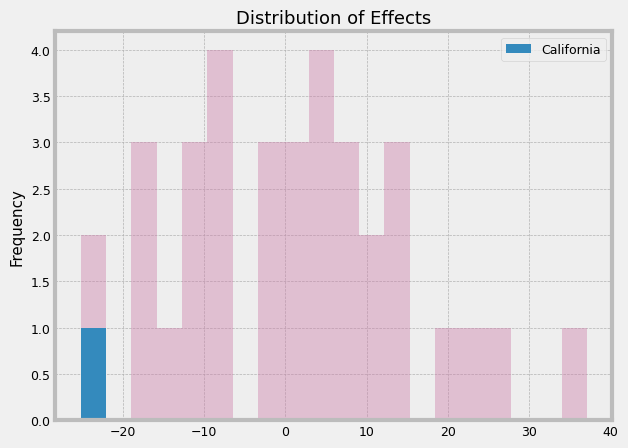

In [251]:
_, bins, _ = plt.hist(effects, bins=20, color='C5', alpha=0.4)
plt.hist([calif_effect], bins=bins, color='C0', label='California')
plt.ylabel('Frequency')
plt.title('Distribution of Effects')
plt.legend();

## Key Ideas

We've learned that if we only have aggregated level data on entities like cities or states, diff-in-diff won't allow us to do inference. Also, it has some other limitations, since it has to define a control unit and one single control unit might not be a very good representation of the counterfactual for the treated unit.

To correct for that, we learned that we can build a synthetic control that combines multiple control units to make them resemble the treated unit. With this synthetic control, we were able to see what would have happened to our treated unit in the absence of a treatment.

Finally, we saw how we could use Fisher's Exact Tests to do inference with synthetic control. Namely, we've pretended that the non-treated units were actually the treated and computed their effect. These were the placebo effects: the effects we would observe even without a treatment. We uses these to see if the treatment effect we've estimated was statistically significant.